# Проект: Обучение с учителем: качество модели. Построение предсказательной модели покупательской активности.

Цель работы - с использованием автоматического перебора гиперпараметров, построить линейную модель машинного обучения, классификации пользователей интернет-магазина по покупательской активности.

**План работы:**
- Загрузить данные из предоставленных csv файлов;
- Предобработать данные (заместить пропуски, привести типы признаков в соответствие, устранить дубликаты, объединить данные, унифицировать категориальные и колличественные признаки, добавить в данные новые признаки);
- Исследовать данные (вычислить границы доверительных диапазонов значений признаков, выявить выбросы значений и аномалии);
- Объединить все наборы данных без потери информации;
- Исследовать корреляции признаков в отношении целевого;
- Построить пайплайн предобработки категориальных и численных признаков и группы линейных моделей (провести поиск лучшей из моделей по метрике качества);
- Дать оценку признакам набора данных по влиянию на прогноз целевого признака;
- Используя обученную модель сегментировать покупателей интернет-магазина по прибыли и прогнозу покупательской активности;
- Общий вывод.

## Подготовка среды анализа данных

### Подключение аналитических библиотек

In [1]:
!pip install --upgrade numpy -q
!pip install --upgrade numba -q
!pip install --upgrade matplotlib -q
!pip install --upgrade scikit-learn -q
!pip install --upgrade seaborn -q
!pip install phik -q
!pip install shap -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.9.1 requires numpy<1.25.0,>=1.18.5, but you have numpy 2.0.2 which is incompatible.
numba 0.56.0 requires numpy<1.23,>=1.18, but you have numpy 2.0.2 which is incompatible.


In [2]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
import shap
from phik.report import correlation_report, plot_correlation_matrix
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    RocCurveDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    mean_absolute_error,
    mean_squared_error,
    precision_score,
    precision_recall_curve,
    r2_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    train_test_split,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    RobustScaler,
    StandardScaler,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

### Настройка аналитических библиотек

In [3]:
pd.options.display.max_columns = None
pd.options.display.max_rows = 400
pd.options.display.max_colwidth = 400
pd.options.display.float_format = '{:,.2f}'.format

warnings.filterwarnings('ignore')

RANDOM_STATE = 27466437
TEST_SIZE = 0.25

### Функции используемые в проекте

In [4]:
def Anderson(distribution):
    """Статистический тест на нормальность распределения"""
    result = st.anderson(distribution, dist = 'norm')
    critical_value = result.critical_values[2]  # 5% уровень значимости (третий элемент)
    print('Статистика теста: {0:.4f}'.format(result.statistic))
    print('Критическое значение для 5% уровня значимости: {0:.4f}'.format(critical_value))
    if result.statistic > critical_value:
        print('Отклоняем H0: распределение НЕ нормальное (p < 0.05)')
    else:
        print('Нет оснований отвергать H0: распределение нормальное (p > 0.05)')

In [5]:
def chart_attribute(attribute_data, attribute_name, x_label, hist_bins = 50):
    """Выводит три диаграммы друг под другом. Верхняя - boxplot, средняя - гистограмма,
    нижняя - scatter значений в наборе данных."""
    plt.figure(figsize = (16, 16))
    
    plot1 = plt.subplot(3, 1, 1)
    plt.boxplot(x = attribute_data, vert = False)
    plot1.xaxis.grid(True)
    plot1.set_title('Диаграмма размаха признака {0}'.format(attribute_name))
    
    plot2 = plt.subplot(3, 1, 2)
    plt.hist(x = attribute_data, bins = hist_bins)
    plot2.grid(visible = True)
    plot2.set_ylabel('Частота')
    plot2.set_xlabel(x_label)
    plot2.set_title('Частотная гистограмма признака {0}'.format(attribute_name))

    plot3 = plt.subplot(3, 1, 3)
    plt.scatter(attribute_data, attribute_data.index, color = 'g', alpha = 0.3)
    plot3.set_title('Диаграмма рассеяния значений признака {0}'.format(attribute_name))
    plot3.set_xlabel(x_label)
    plot3.set_ylabel('индекс записи')
    
    plt.show()

In [6]:
def chart_attribute_pie(attribute_data, attribute_labels, attribute_name):
    """Выводит круговую диаграмму по значениям признака. Информация по секторам:
    наименование, абсолютное количество, относительная доля."""
    attribute_total = attribute_data.sum()
    pies = [x / attribute_total for x in attribute_data]
    labels = [f'{a}\n{b}' for a, b in zip(attribute_labels.tolist(), attribute_data.tolist())]
    plt.figure(figsize = (9, 9))
    plt.pie(pies, labels = labels, autopct = '%1.1f%%', startangle = 90)
    plt.title('Круговая диаграмма распределения признака {0}'.format(attribute_name))
    plt.show()

In [7]:
def chart_attribute_discrete(attribute_data, attribute_name, attribute_label):
    """Выводит столбчатую диаграмму по количествам значений признака."""
    plt.figure(figsize = (9, 9))
    ax = sns.countplot(attribute_data.to_frame(attribute_label), x = attribute_label)
    for container in ax.containers:
        ax.bar_label(container)
    plt.title('Столбчатая диаграмма количеств значений признака {0}'.format(attribute_name))
    plt.show()

In [8]:
def get_vif_scores(data):
    """Рассчитывает Variance inflation factor метрики для колличественных признаков в наборе данных."""
    X = add_constant(data)
    vif = pd.DataFrame()
    vif['Признак'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) 
                  for i in range(X.shape[1])]
    return vif[vif['Признак'] != 'const'].sort_values('VIF', ascending=False)

In [9]:
def scatter_attr(dataset, attr):
    plt.figure(figsize = (10, 10))
    values = sorted(dataset[attr].unique().tolist())
    for value in values:
        data_y = dataset[dataset[attr] == value]['прибыль']
        data_x = dataset[dataset[attr] == value]['вероятность']
        plt.scatter(x = data_x, y = data_y, label = value, alpha = 0.6)
    #plt.title('Диаграмма распределения лояльности покупателей')
    plt.xlabel('вероятность')
    plt.ylabel('прибыль')
    plt.legend(loc = 'upper left')
    plt.grid(True)
    plt.show()

## Загрузка данных

Загрузим данные. Файлы market_file.csv, market_money.csv, market_time.csv, money.csv.

### Файл market_file.csv

In [10]:
try:
    dataset_market = pd.read_csv('/datasets/market_file.csv')
except:
    display('Ошибка загрузки набора данных о пользователях!')

In [11]:
display(dataset_market.info())
display(dataset_market.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

None

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.40,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.40,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.90,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.20,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.10,3,1064,0.94,Товары для детей,3,2,3,2
5,215353,Снизилась,стандартт,да,3.30,4,762,0.26,Домашний текстиль,4,1,1,4
6,215354,Снизилась,стандартт,да,5.10,3,431,0.23,Косметика и аксесуары,2,3,7,2
7,215355,Снизилась,стандартт,нет,4.70,4,284,0.17,Товары для детей,5,1,6,4
8,215356,Снизилась,стандартт,да,4.20,4,192,0.14,Косметика и аксесуары,2,2,1,3
9,215357,Снизилась,стандартт,да,3.90,5,154,0.00,Техника для красоты и здоровья,3,3,9,5


### Файл market_money.csv

In [12]:
try:
    dataset_market_money = pd.read_csv('/datasets/market_money.csv')
except:
    display('Ошибка загрузки набора данных о пользователях!')

In [13]:
display(dataset_market_money.info())
display(dataset_market_money.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


None

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.00
1,215348,текущий_месяц,"3,293.10"
2,215348,предыдущий_месяц,0.00
3,215349,препредыдущий_месяц,"4,472.00"
4,215349,текущий_месяц,"4,971.60"
5,215349,предыдущий_месяц,"5,216.00"
6,215350,препредыдущий_месяц,"4,826.00"
7,215350,текущий_месяц,"5,058.40"
8,215350,предыдущий_месяц,"5,457.50"
9,215351,текущий_месяц,"6,610.40"


### Файл market_time.csv

In [14]:
try:
    dataset_market_time = pd.read_csv('/datasets/market_time.csv')
except:
    display('Ошибка загрузки набора данных о пользователях!')

In [15]:
display(dataset_market_time.info())
display(dataset_market_time.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


None

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13
5,215350,предыдцщий_месяц,8
6,215351,текущий_месяц,13
7,215351,предыдцщий_месяц,11
8,215352,текущий_месяц,11
9,215352,предыдцщий_месяц,8


### Файл money.csv

In [16]:
try:
    dataset_money = pd.read_csv('/datasets/money.csv', sep = ';', decimal = ',')
except:
    display('Ошибка загрузки набора данных о пользователях!')

In [17]:
display(dataset_money.info())
display(dataset_money.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


None

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21
5,215353,3.95
6,215354,3.62
7,215355,5.26
8,215356,4.93
9,215357,4.66


### Предварительная оценка данных

Четыре набора данных представляют взаимосвязанные таблицы. Ключ связей - идентификатор покупателя id.

    Набор данных dataset_market, является справочником текущего состояния клиентской базы и содержит 1300 записей. Все типы признаков распознаны библиотекой pandas корректно.
    Признаки описывающие коммуникации с клиентом:
    - Тип_сервиса;
    - Разрешить_сообщать;
    - Маркет_актив_6_мес;
    - Маркет_актив_тек_мес;
    - Длительность.
    Признаки описывающие продуктовое поведение покупателя:
    - Акционные_покупки;
    - Популярная_категория;
    - Неоплаченные_продукты_штук_квартал;
    Признаки описывающие поведение покупателя в интернет-магазине:
    - Средний_просмотр_категорий_за_визит;
    - Страниц_за_визит;
    - Ошибка_сервиса.
    
    Набор данных dataset_market_money, является журналом торговой выручки интернет-магазина по календарным периодам и содержит 3900 записей. Все типы признаков распознаны библиотекой pandas корректно.
    Признаки описывающие финансовое поведение клиентов:
    - Период;
    - Выручка.
     
    Набор данных dataset_market_time, является журналом регистрации времени проведённого на сайте интернет-магазина пользователями и содержит 2600 записей. Все типы признаков распознаны библиотекой pandas корректно.
    Признаки описывающие поведение покупателя в интернет-магазине:
    - Период;
    - Присутствие_минут.
    
    Набор данных dataset_money, является реестром покупателей интернет-магазина и содержит 1300 записей.
    Признаки описывающие рейтинг покупателя в интернет-магазине:
    - Прибыль.

## Предобработка данных

### Переименование признаков

Перепишем наименования признаков в наборах данных dataset_market и dataset_market_time, в соответствии с соглашением PEP8 snake_case.

In [18]:
dataset_market.rename(columns = lambda с: с.lower().replace(' ', '_'), inplace = True)
dataset_market_money.rename(columns = lambda с: с.lower().replace(' ', '_'), inplace = True)
dataset_market_time.rename(columns = lambda с: с.lower().replace(' ', '_'), inplace = True)
dataset_money.rename(columns = lambda с: с.lower().replace(' ', '_'), inplace = True)

### Устранение пропусков данных

Проверим наличие пропусков значений признаков в каждом из наборов данных.

In [19]:
dataset_market.isna().sum()

id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
dtype: int64

In [20]:
dataset_market_money.isna().sum()

id         0
период     0
выручка    0
dtype: int64

In [21]:
dataset_market_time.isna().sum()

id        0
период    0
минут     0
dtype: int64

In [22]:
dataset_money.isna().sum()

id         0
прибыль    0
dtype: int64

Пропущеных значений ни в одном из наборов данных не выявленно.

### Устранение неявных дубликатов

Рассмотрим уникальные значения категориальных признаков в наборе данных dataset_market, dataset_market_money и dataset_market_time.

In [23]:
print(*dataset_market['покупательская_активность'].unique().tolist(), sep = '\n')

Снизилась
Прежний уровень


In [24]:
print(*dataset_market['тип_сервиса'].unique().tolist(), sep = '\n')

премиум
стандартт
стандарт


Есть опечатки в значениях признака.

In [25]:
print(*dataset_market['разрешить_сообщать'].unique().tolist(), sep = '\n')

да
нет


In [26]:
print(*dataset_market['популярная_категория'].unique().tolist(), sep = '\n')

Товары для детей
Домашний текстиль
Косметика и аксесуары
Техника для красоты и здоровья
Кухонная посуда
Мелкая бытовая техника и электроника


In [27]:
print(*dataset_market_money['период'].unique().tolist(), sep = '\n')

препредыдущий_месяц
текущий_месяц
предыдущий_месяц


In [28]:
print(*dataset_market_time['период'].unique().tolist(), sep = '\n')

текущий_месяц
предыдцщий_месяц


Есть опечатки в значениях признака.

Очевидно, что среди значений признака 'тип_сервиса' набора данных dataset_market и значений признака 'период' набора данных dataset_market_time, содержатся ошибки. Следует их исправить.

In [29]:
dataset_market['тип_сервиса'].replace('стандартт', 'стандарт', inplace = True)
dataset_market_time['период'].replace('предыдцщий_месяц', 'предыдущий_месяц', inplace = True)

Неявные дубликаты значений в наборах данных устранены.

### Устранение явных дубликатов

Выведем явные дубликаты в наборах данных.

In [30]:
dataset_market[dataset_market.duplicated(keep = False)].sort_values(by = 'id')

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит


In [31]:
dataset_market_money[dataset_market_money.duplicated(keep = False)].sort_values(by = 'id')

,id,период,выручка


In [32]:
dataset_market_time[dataset_market_time.duplicated(keep = False)].sort_values(by = 'id')

,id,период,минут


In [33]:
dataset_money[dataset_money.duplicated(keep = False)].sort_values(by = 'id')

,id,прибыль


Явных дубликатов в значениях наборов данных нет.

## Исследовательский анализ данных

Для визуализации характеристик распределения значений признаков используем следующие функции

In [34]:
print(chart_attribute.__doc__)

Выводит три диаграммы друг под другом. Верхняя - boxplot, средняя - гистограмма,
    нижняя - scatter значений в наборе данных.


In [35]:
print(chart_attribute_pie.__doc__)

Выводит круговую диаграмму по значениям признака. Информация по секторам:
    наименование, абсолютное количество, относительная доля.


In [36]:
print(chart_attribute_discrete.__doc__)

Выводит столбчатую диаграмму по количествам значений признака.


In [37]:
print(Anderson.__doc__)

Статистический тест на нормальность распределения


### Выделение неактивных пользователей

Прежде всего, исключим из рассмотрения пользователей, не проявивших покупательскую активность в любой из трёх последних месяцев.

In [38]:
inactive_users = dataset_market_money[dataset_market_money['выручка'] == 0]['id'].unique().tolist()

dataset_market = dataset_market[~dataset_market['id'].isin(inactive_users)]
dataset_market_money = dataset_market_money[~dataset_market_money['id'].isin(inactive_users)]
dataset_market_time = dataset_market_time[~dataset_market_time['id'].isin(inactive_users)]
dataset_money = dataset_money[~dataset_money['id'].isin(inactive_users)]

print('Всего неактивных пользователей: {0}'. format(len(inactive_users)))

Всего неактивных пользователей: 3


### Набор данных dataset_market, признак 'покупательская_активность'

Рассмотрим спектр значений признака.

In [39]:
data_покупательская_активность = dataset_market[['id', 'покупательская_активность']]
data_покупательская_активность['покупательская_активность'].value_counts()

Прежний уровень    802
Снизилась          495
Name: покупательская_активность, dtype: int64

Признак - категориальный. Спектр значений - бинарный.

Представим распределение в виде круговой диаграммы.

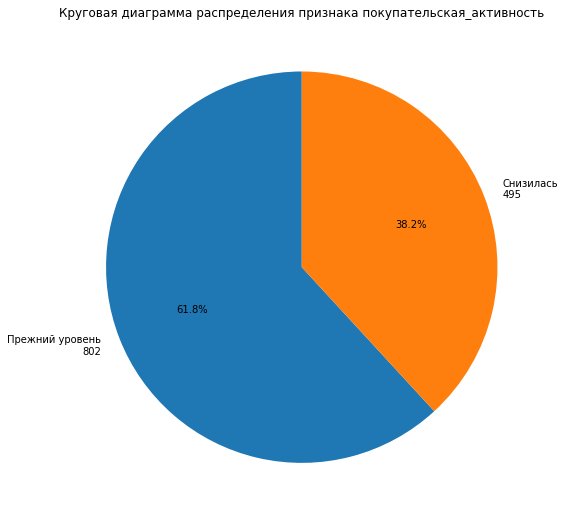

In [40]:
data_покупательская_активность_grouped_aggregated = data_покупательская_активность.groupby(by = 'покупательская_активность',\
                                                                     as_index = True, sort = True).agg({'id': 'count'})
chart_attribute_pie(data_покупательская_активность_grouped_aggregated['id'],\
                    data_покупательская_активность_grouped_aggregated.index, 'покупательская_активность')

Распределение значений признака несбалансированно по классам.

### Набор данных dataset_market, признак 'тип_сервиса'

Рассмотрим спектр значений признака.

In [41]:
data_тип_сервиса = dataset_market[['id', 'тип_сервиса']]
data_тип_сервиса['тип_сервиса'].value_counts()

стандарт    922
премиум     375
Name: тип_сервиса, dtype: int64

Признак - категориальный. Спектр значений - бинарный.

Представим распределение в виде круговой диаграммы.

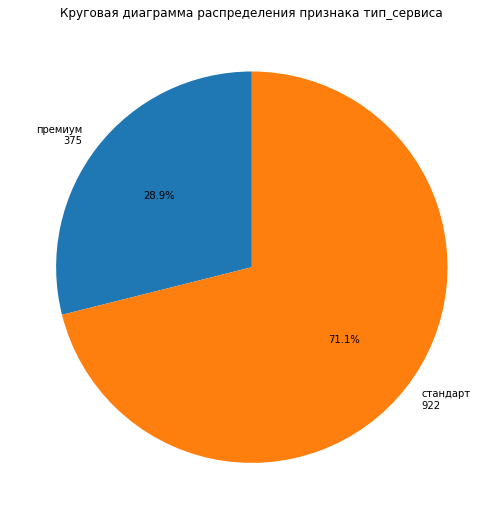

In [42]:
data_тип_сервиса_grouped_aggregated = data_тип_сервиса.groupby(by = 'тип_сервиса',\
                                                                     as_index = True, sort = True).agg({'id': 'count'})
chart_attribute_pie(data_тип_сервиса_grouped_aggregated['id'],\
                    data_тип_сервиса_grouped_aggregated.index, 'тип_сервиса')

Распределение значений признака несбалансированно по классам.

### Набор данных dataset_market, признак 'разрешить_сообщать'

Рассмотрим спектр значений признака.

In [43]:
data_разрешить_сообщать = dataset_market[['id', 'разрешить_сообщать']]
data_разрешить_сообщать['разрешить_сообщать'].value_counts()

да     959
нет    338
Name: разрешить_сообщать, dtype: int64

Признак - категориальный. Спектр значений - бинарный.

Представим распределение в виде круговой диаграммы.

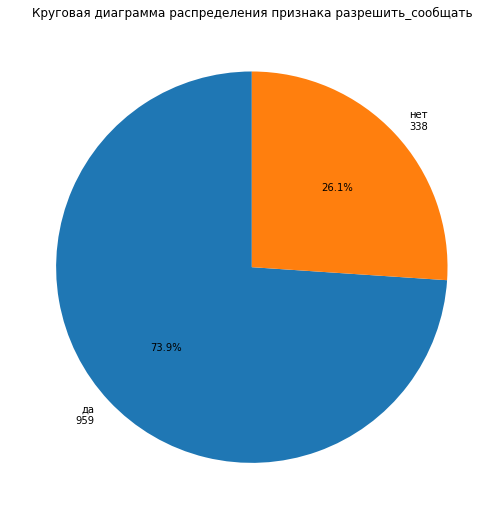

In [44]:
data_разрешить_сообщать_grouped_aggregated = data_разрешить_сообщать.groupby(by = 'разрешить_сообщать',\
                                                                     as_index = True, sort = True).agg({'id': 'count'})
chart_attribute_pie(data_разрешить_сообщать_grouped_aggregated['id'],\
                    data_разрешить_сообщать_grouped_aggregated.index, 'разрешить_сообщать')

Распределение значений признака несбалансированно по классам.

### Набор данных dataset_market, признак 'маркет_актив\_6\_мес'

Рассмотрим спектр значений признака.

In [45]:
data_маркет_актив_6_мес = dataset_market['маркет_актив_6_мес']
data_маркет_актив_6_мес.describe()

count   1,297.00
mean        4.25
std         1.02
min         0.90
25%         3.70
50%         4.20
75%         4.90
max         6.60
Name: маркет_актив_6_мес, dtype: float64

Признак - численный.

In [46]:
data_маркет_актив_6_мес.nunique()

41

В спектре значений 41 уникальная величина.

Представим распределение в виде диаграммы размаха и гистограммы.

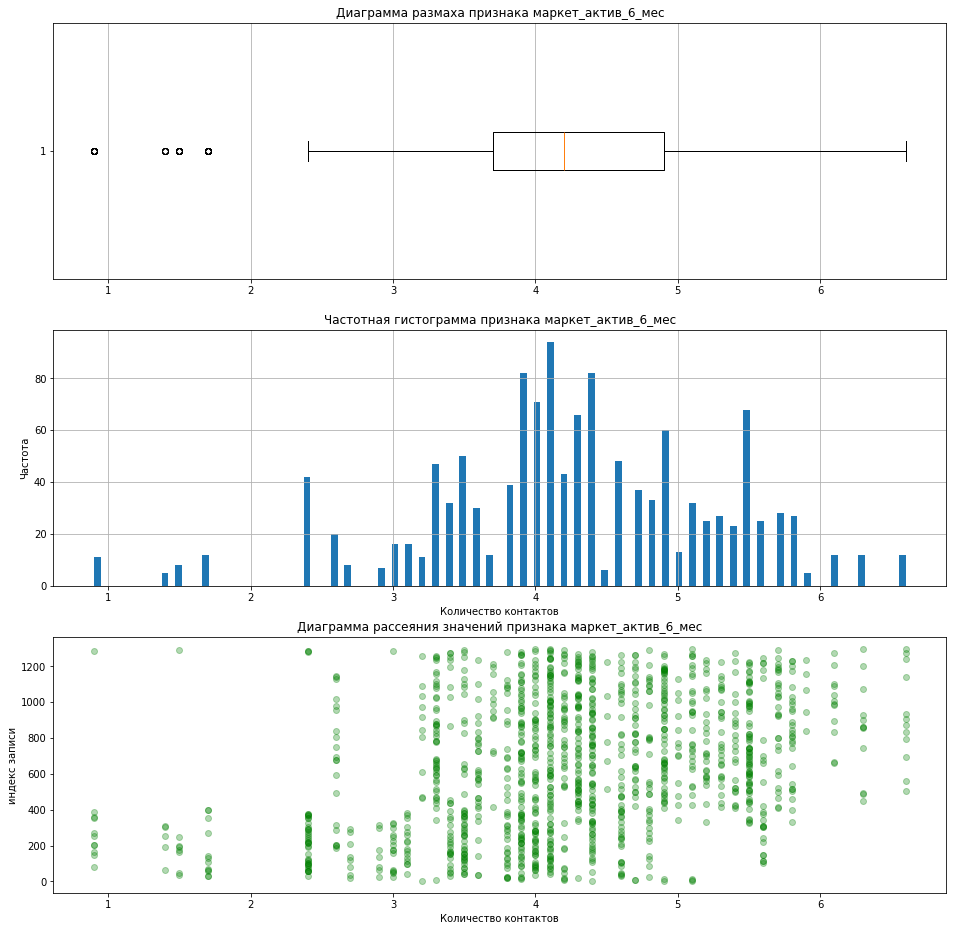

In [47]:
chart_attribute(data_маркет_актив_6_мес, 'маркет_актив_6_мес', 'Количество контактов', 120)

Протестируем распределение значений признака, тестом Андерсона-Дарлинга. Выдвинем гипотезу Н0, о нормальности распределения.

In [48]:
Anderson(data_маркет_актив_6_мес)

Статистика теста: 6.6409
Критическое значение для 5% уровня значимости: 0.7850
Отклоняем H0: распределение НЕ нормальное (p < 0.05)


Распределение значений признака - нельзя считать нормальным.

### Набор данных dataset_market, признак 'маркет_актив_тек_мес'

Рассмотрим спектр значений признака.

In [49]:
data_маркет_актив_тек_мес = dataset_market['маркет_актив_тек_мес']
data_маркет_актив_тек_мес.describe()

count   1,297.00
mean        4.01
std         0.70
min         3.00
25%         4.00
50%         4.00
75%         4.00
max         5.00
Name: маркет_актив_тек_мес, dtype: float64

Признак - численный.

In [50]:
data_маркет_актив_тек_мес.nunique()

3

В спектре значений всего 3 уникальных величины.

Представим распределение в виде столючатой диаграммы со счётом.

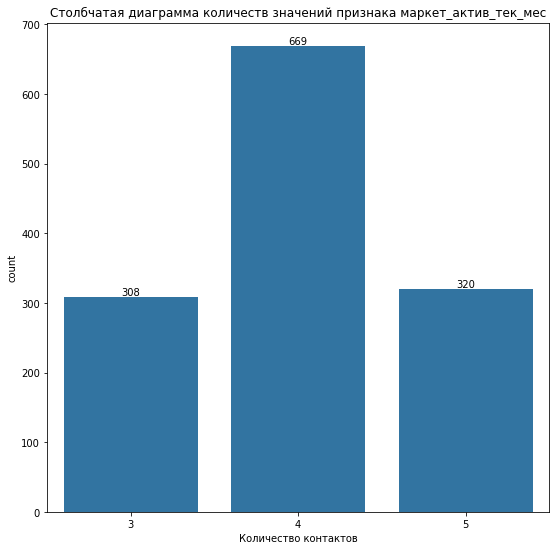

In [51]:
chart_attribute_discrete(data_маркет_актив_тек_мес, 'маркет_актив_тек_мес', 'Количество контактов')

Распределение значений признака несбалансированно по классам.

### Набор данных dataset_market, признак 'длительность'

Рассмотрим спектр значений признака.

In [52]:
data_длительность = dataset_market['длительность']
data_длительность.describe()

count   1,297.00
mean      602.99
std       249.10
min       121.00
25%       410.00
50%       607.00
75%       806.00
max     1,079.00
Name: длительность, dtype: float64

Признак - численный.

In [53]:
data_длительность.nunique()

657

В спектре значений 657 уникальных величин.

Представим распределение в виде диаграммы размаха и гистограммы.

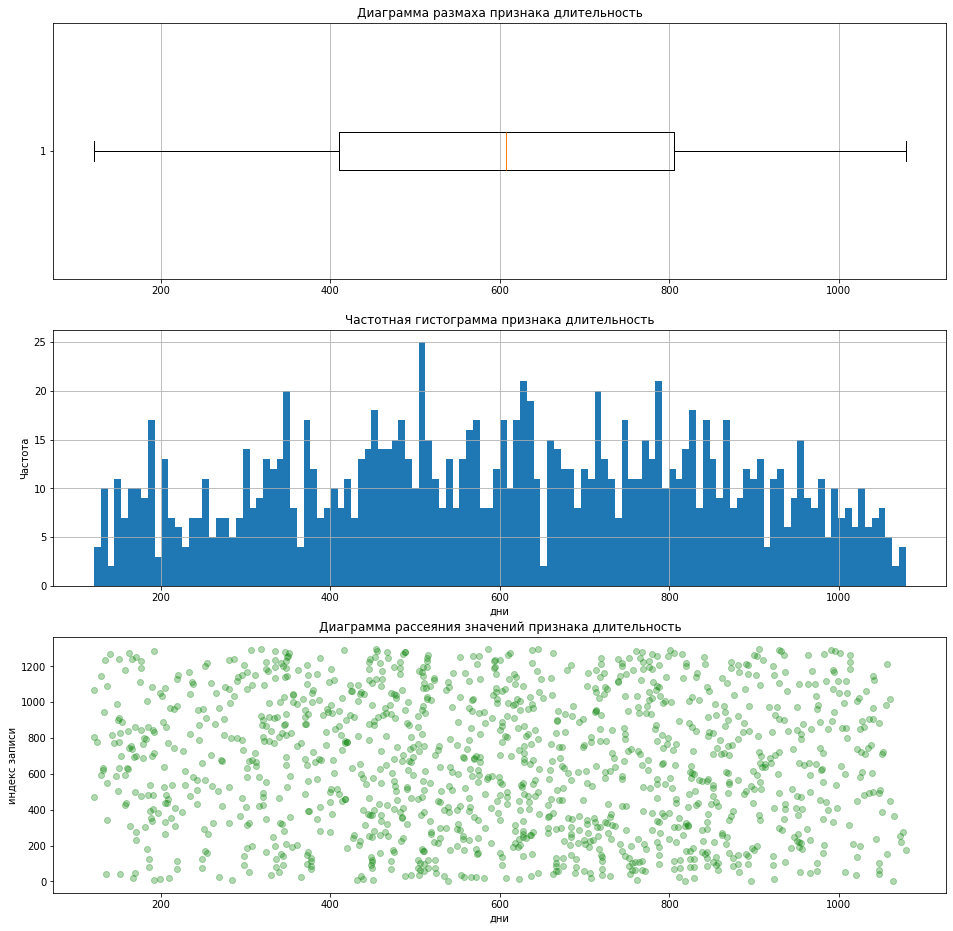

In [54]:
chart_attribute(data_длительность, 'длительность', 'дни',  120)

Протестируем распределение значений признака, тестом Андерсона-Дарлинга. Выдвинем гипотезу Н0, о нормальности распределения.

In [55]:
Anderson(data_длительность)

Статистика теста: 7.3728
Критическое значение для 5% уровня значимости: 0.7850
Отклоняем H0: распределение НЕ нормальное (p < 0.05)


Распределение значений признака - нельзя считать нормальным.

### Набор данных dataset_market, признак 'акционные_покупки'

Рассмотрим спектр значений признака.

In [56]:
data_акционные_покупки = dataset_market['акционные_покупки']
data_акционные_покупки.describe()

count   1,297.00
mean        0.32
std         0.25
min         0.11
25%         0.17
50%         0.24
75%         0.30
max         0.99
Name: акционные_покупки, dtype: float64

Признак - численный.

In [57]:
data_акционные_покупки.nunique()

41

В спектре значений 41 уникальная величина.

Представим распределение в виде диаграммы размаха и гистограммы.

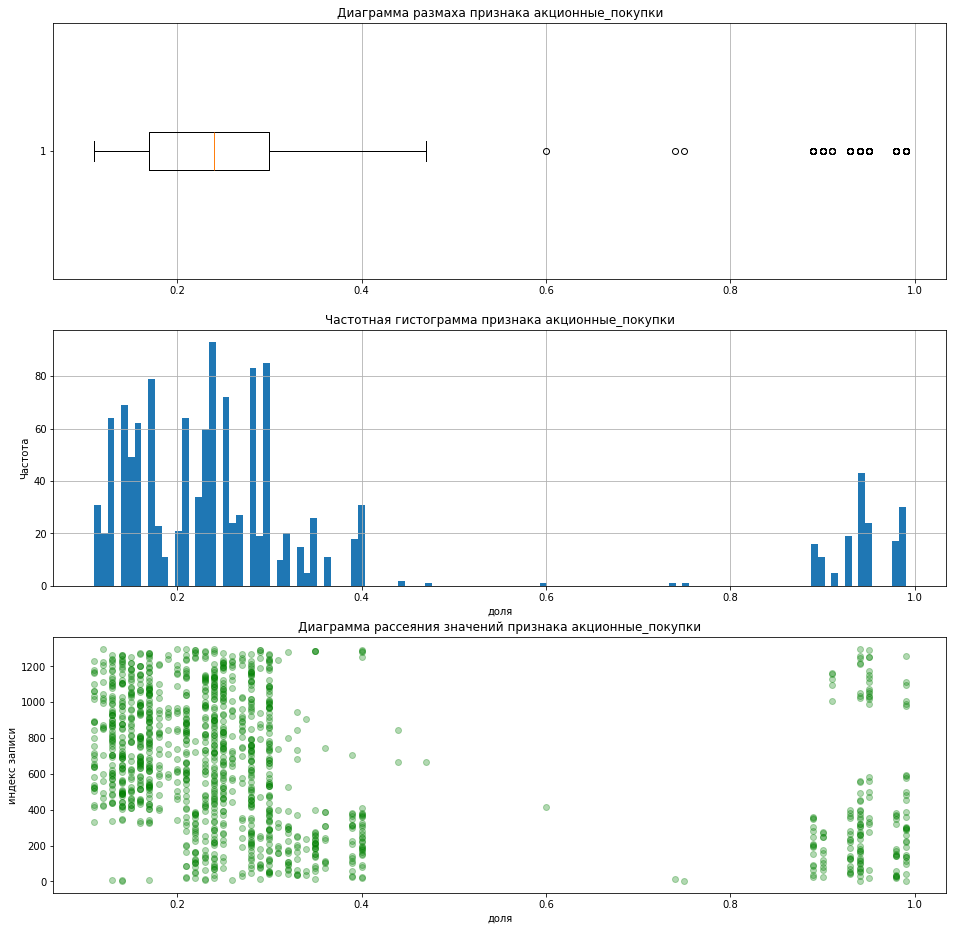

In [58]:
chart_attribute(data_акционные_покупки, 'акционные_покупки', 'доля',  120)

Очевидно, что без статистического теста, можно утверждать о не нормальности распределения значений признака.

### Набор данных dataset_market, признак 'популярная_категория'

In [59]:
data_популярная_категория = dataset_market[['id', 'популярная_категория']]
data_популярная_категория['популярная_категория'].value_counts()

Товары для детей                        329
Домашний текстиль                       250
Косметика и аксесуары                   223
Техника для красоты и здоровья          183
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: популярная_категория, dtype: int64

Признак - категориальный. Спектр значений - дискретный.

Представим распределение в виде круговой диаграммы.

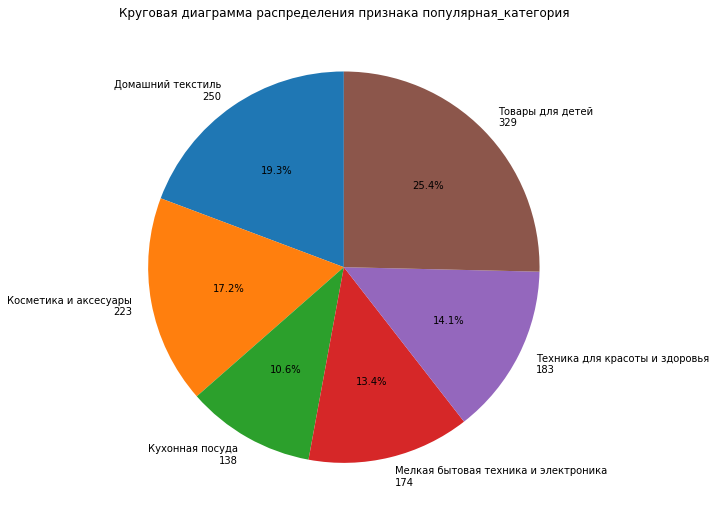

In [60]:
data_популярная_категория_grouped_aggregated = data_популярная_категория.groupby(by = 'популярная_категория',\
                                                                     as_index = True, sort = True).agg({'id': 'count'})
chart_attribute_pie(data_популярная_категория_grouped_aggregated['id'],\
                    data_популярная_категория_grouped_aggregated.index, 'популярная_категория')

Распределение значений признака по классам, можно считать сбалансированым.

### Набор данных dataset_market, признак 'средний_просмотр_категорий_за_визит'

Рассмотрим спектр значений признака.

In [61]:
data_средний_просмотр_категорий_за_визит = dataset_market['средний_просмотр_категорий_за_визит']
data_средний_просмотр_категорий_за_визит.describe()

count   1,297.00
mean        3.27
std         1.35
min         1.00
25%         2.00
50%         3.00
75%         4.00
max         6.00
Name: средний_просмотр_категорий_за_визит, dtype: float64

Признак - численный.

In [62]:
data_средний_просмотр_категорий_за_визит.nunique()

6

В спектре значений всего 6 уникальных величины.

Представим распределение в виде столючатой диаграммы со счётом.


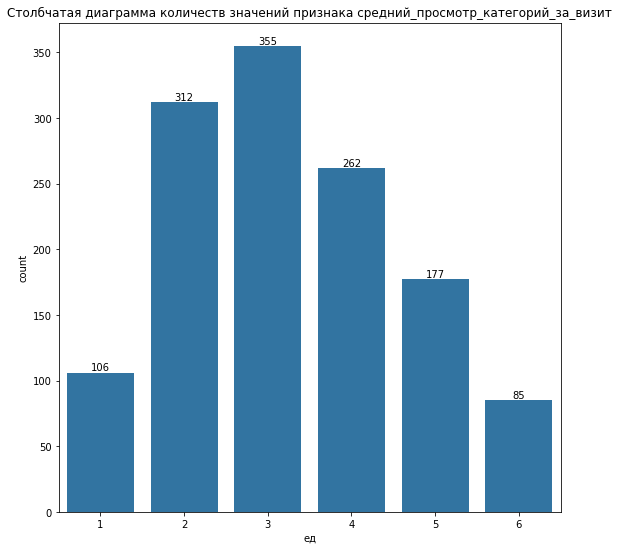

In [63]:
chart_attribute_discrete(data_средний_просмотр_категорий_за_визит, 'средний_просмотр_категорий_за_визит', 'ед')

Распределение значений признака несбалансированно по классам.

### Набор данных dataset_market, признак 'неоплаченные_продукты_штук_квартал'

Рассмотрим спектр значений признака.

In [64]:
data_неоплаченные_продукты_штук_квартал = dataset_market['неоплаченные_продукты_штук_квартал']
data_неоплаченные_продукты_штук_квартал.describe()

count   1,297.00
mean        2.84
std         1.97
min         0.00
25%         1.00
50%         3.00
75%         4.00
max        10.00
Name: неоплаченные_продукты_штук_квартал, dtype: float64

Признак - численный.

In [65]:
data_неоплаченные_продукты_штук_квартал.nunique()

11

В спектре значений всего 11 уникальных величины.

Представим распределение в виде столючатой диаграммы со счётом.

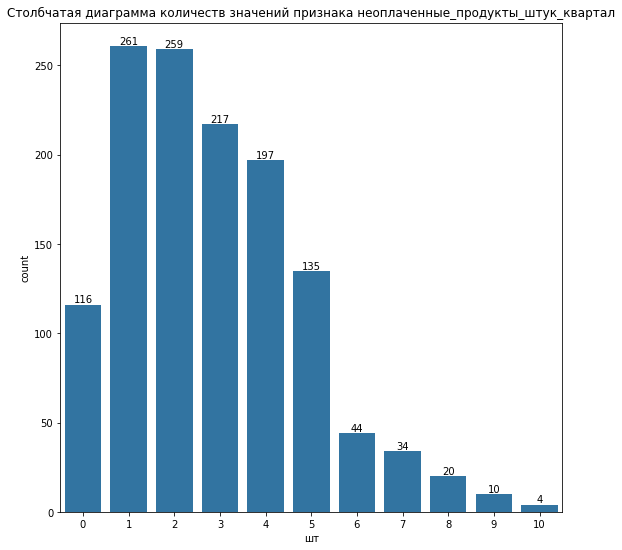

In [66]:
chart_attribute_discrete(data_неоплаченные_продукты_штук_квартал, 'неоплаченные_продукты_штук_квартал', 'шт')

Распределение значений признака несбалансированно по классам.

### Набор данных dataset_market, признак 'ошибка_сервиса'

Рассмотрим спектр значений признака.

In [67]:
data_ошибка_сервиса = dataset_market['ошибка_сервиса']
data_ошибка_сервиса.describe()

count   1,297.00
mean        4.18
std         1.95
min         0.00
25%         3.00
50%         4.00
75%         6.00
max         9.00
Name: ошибка_сервиса, dtype: float64

Признак - численный.

In [68]:
data_ошибка_сервиса.nunique()

10

В спектре значений всего 10 уникальных величины.

Представим распределение в виде столючатой диаграммы со счётом.


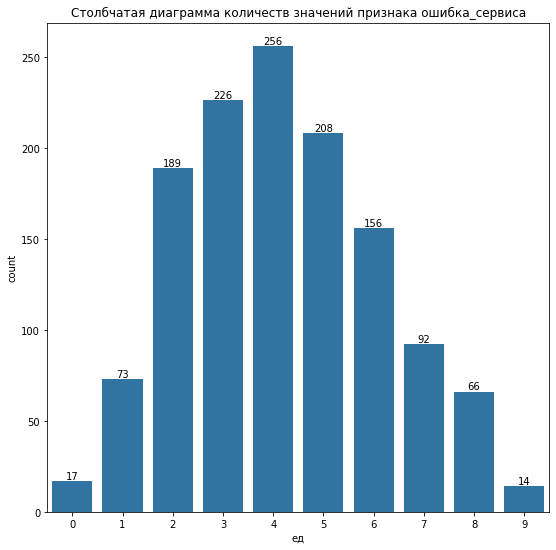

In [69]:
chart_attribute_discrete(data_ошибка_сервиса, 'ошибка_сервиса', 'ед')

Распределение значений признака несбалансированно по классам.

### Набор данных dataset_market, признак 'страниц_за_визит'

Рассмотрим спектр значений признака.

In [70]:
data_страниц_за_визит = dataset_market['страниц_за_визит']
data_страниц_за_визит.describe()

count   1,297.00
mean        8.19
std         3.98
min         1.00
25%         5.00
50%         8.00
75%        11.00
max        20.00
Name: страниц_за_визит, dtype: float64

Признак - численный.

In [71]:
data_страниц_за_визит.nunique()

20

В спектре значений 20 уникальная величина.

Представим распределение в виде диаграммы размаха и гистограммы.

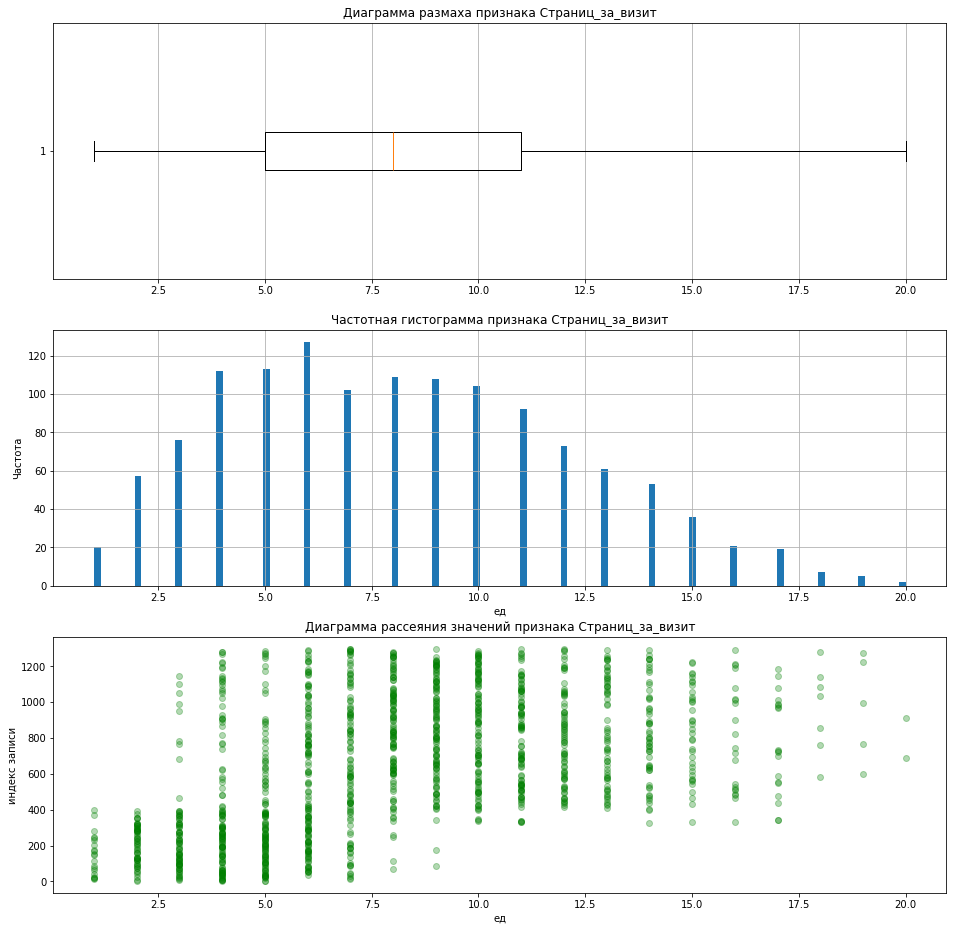

In [72]:
chart_attribute(data_страниц_за_визит, 'Страниц_за_визит', 'ед',  120)

Протестируем распределение значений признака, тестом Андерсона-Дарлинга. Выдвинем гипотезу Н0, о нормальности распределения.

In [73]:
Anderson(data_страниц_за_визит)

Статистика теста: 9.5429
Критическое значение для 5% уровня значимости: 0.7850
Отклоняем H0: распределение НЕ нормальное (p < 0.05)


Распределение значений признака - нельзя считать нормальным.

### Набор данных dataset_market_money, признак 'период'

Рассмотрим спектр значений признака.

In [ ]:
data_money_период = dataset_market_money[['id', 'период']]
data_money_период['период'].value_counts()

Признак - категориальный. Спектр значений - дискретный.

Представим распределение в виде круговой диаграммы.

In [ ]:
data_money_период_grouped_aggregated = data_money_период.groupby(by = 'период',\
                                                                     as_index = True, sort = True).agg({'id': 'count'})
chart_attribute_pie(data_money_период_grouped_aggregated['id'],\
                    data_money_период_grouped_aggregated.index, 'период')

Распределение значений признака сбалансированно по классам.

### Набор данных dataset_market_money, признак 'выручка'

Рассмотрим спектр значений признака.

In [41]:
data_money_выручка = dataset_market_money['выручка']
data_money_выручка.describe()

count     3,891.00
mean      5,033.72
std       1,768.47
min       2,758.70
25%       4,592.00
50%       4,959.00
75%       5,363.20
max     106,862.20
Name: выручка, dtype: float64

Признак - численный.

In [42]:
data_money_выручка.nunique()

2773

В спектре значений 2773 уникальных величин.

Представим распределение в виде диаграммы размаха и гистограммы.

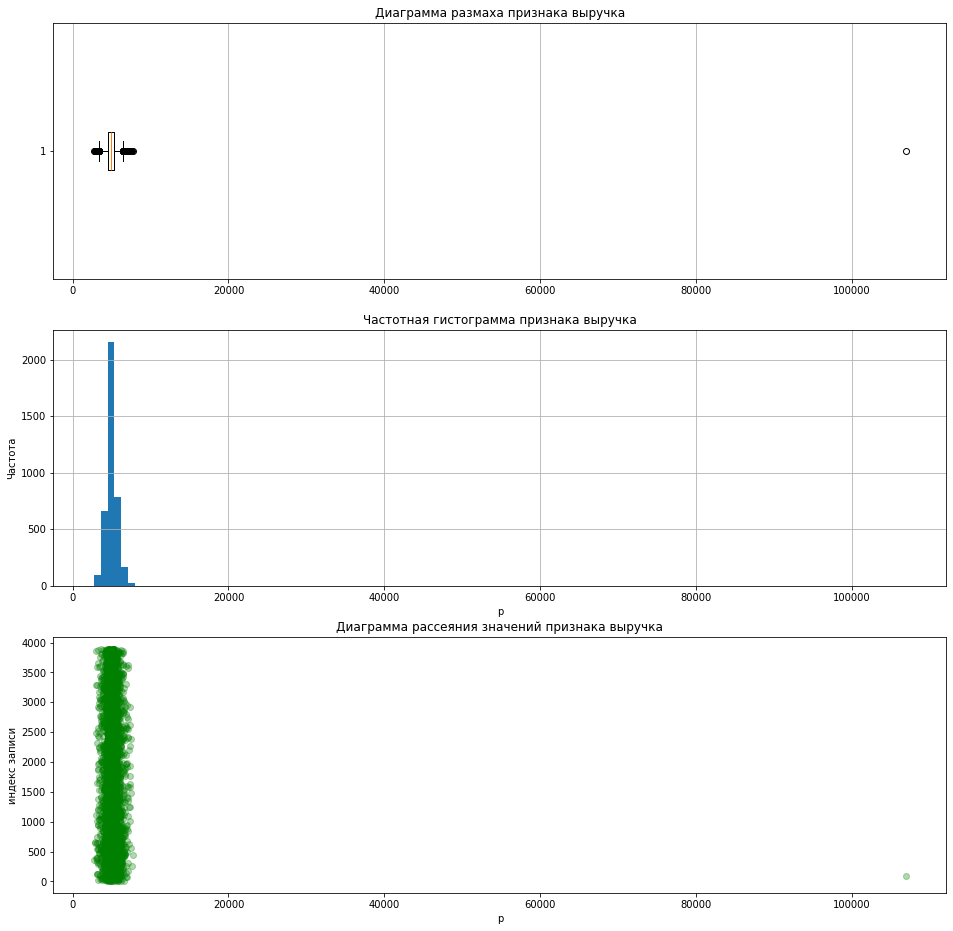

In [43]:
chart_attribute(data_money_выручка, 'выручка', 'р',  120)

Аномально большое значение. Следует удалить.

Выведем запись набора данных dataset_market_money с аномально высоким значением выручки.

In [44]:
display(dataset_market_money[dataset_market_money['выручка'] > 100000])

,id,период,выручка
98,215380,текущий_месяц,"106,862.20"


In [45]:
dataset_market_money = dataset_market_money[dataset_market_money['id'] != 215380]

Повторим построение и визуализацию поднабора данных без аномальной выручки.

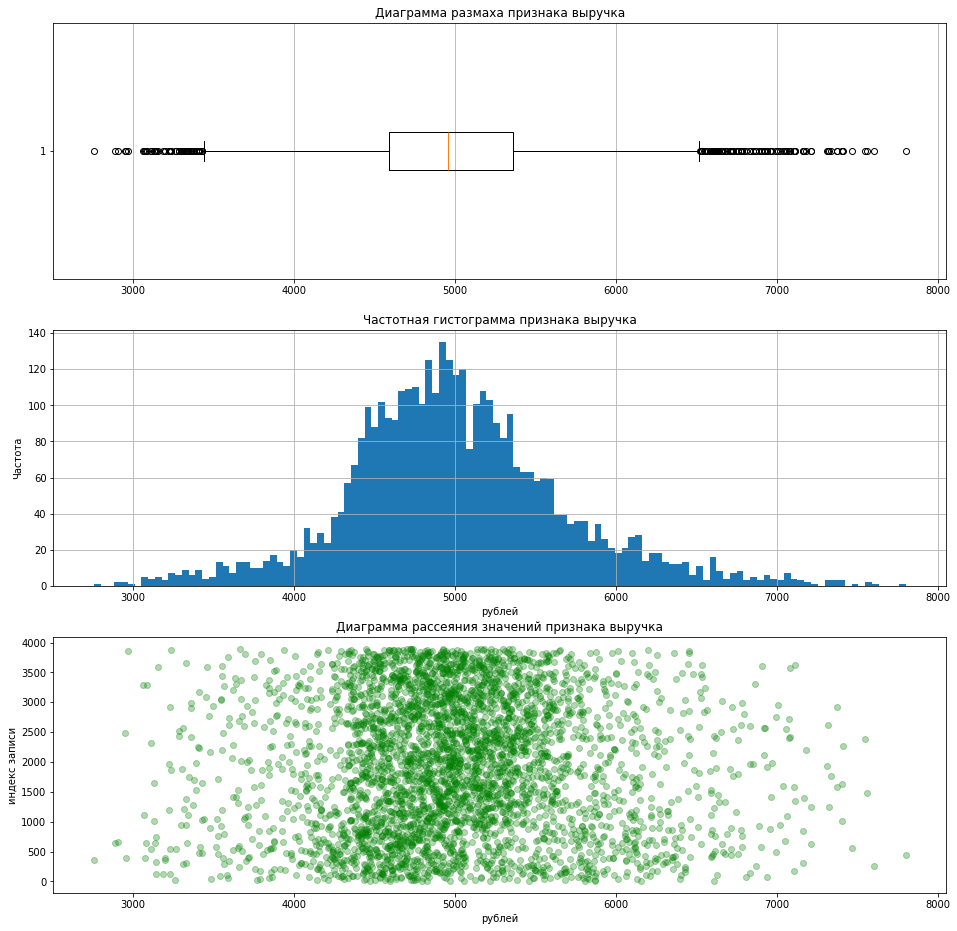

In [46]:
data_money_выручка = dataset_market_money['выручка']
chart_attribute(data_money_выручка, 'выручка', 'рублей',  120)

Протестируем распределение значений признака, тестом Андерсона-Дарлинга. Выдвинем гипотезу Н0, о нормальности распределения.

In [47]:
Anderson(data_money_выручка)

Статистика теста: 21.8402
Критическое значение для 5% уровня значимости: 0.7860
Отклоняем H0: распределение НЕ нормальное (p < 0.05)


Распределение значений признака - нельзя считать нормальным.

### Набор данных dataset_market_money, трансформация признака 'выручка'

Развернём набор данных dataset_market_money, так что бы выручки по периодам стали отдельными признаками.

In [48]:
dataset_market_money = dataset_market_money.pivot(index='id', columns='период', values='выручка')
dataset_market_money = dataset_market_money.add_prefix('выручка_')

In [49]:
dataset_market_money.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 215349 to 216647
Data columns (total 3 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   выручка_предыдущий_месяц     1296 non-null   float64
 1   выручка_препредыдущий_месяц  1296 non-null   float64
 2   выручка_текущий_месяц        1296 non-null   float64
dtypes: float64(3)
memory usage: 40.5 KB


In [50]:
dataset_market_money.sample(5)

период,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц
id,,,
215577,"4,942.00","4,774.00","5,663.50"
216542,"5,173.00","5,028.00","5,175.60"
216247,"5,665.00","5,268.00","5,450.50"
215845,"5,514.50","5,120.00","5,986.40"
216010,"4,719.00","5,028.00","4,581.20"


**Выручка за препредыдущий месяц**

In [ ]:
chart_attribute(dataset_market_money['выручка_препредыдущий_месяц'], 'выручка-препредыдущий_месяц', 'рублей',  120)

In [ ]:
Anderson(dataset_market_money['выручка_препредыдущий_месяц'])

**Выручка за предыдущий месяц**

In [ ]:
chart_attribute(dataset_market_money['выручка_предыдущий_месяц'], 'выручка-предыдущий_месяц', 'рублей',  120)

In [ ]:
Anderson(dataset_market_money['выручка_предыдущий_месяц'])

**Выручка за текущий месяц**

In [ ]:
chart_attribute(dataset_market_money['выручка_текущий_месяц'], 'выручка-текущий_месяц', 'рублей',  120)

In [ ]:
Anderson(dataset_market_money['выручка_текущий_месяц'])

### Набор данных dataset_market_time, признак 'период'

Рассмотрим спектр значений признака.

In [51]:
data_time_период = dataset_market_time[['id', 'период']]
data_time_период['период'].value_counts()

текущий_месяц       1297
предыдущий_месяц    1297
Name: период, dtype: int64

Признак - категориальный. Спектр значений - бинарный.

Представим распределение в виде круговой диаграммы.

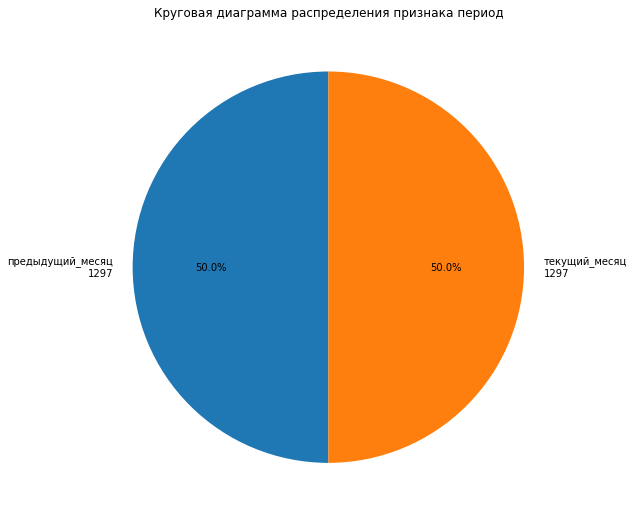

In [52]:
data_time_период_grouped_aggregated = data_time_период.groupby(by = 'период',\
                                                                     as_index = True, sort = True).agg({'id': 'count'})
chart_attribute_pie(data_time_период_grouped_aggregated['id'],\
                    data_time_период_grouped_aggregated.index, 'период')

Распределение значений признака сбалансированно по классам.

### Набор данных dataset_market_time, признак 'минут'

Рассмотрим спектр значений признака.

In [53]:
data_time_минут = dataset_market_time['минут']
data_time_минут.describe()

count   2,594.00
mean       13.34
std         4.08
min         4.00
25%        10.00
50%        13.00
75%        16.00
max        23.00
Name: минут, dtype: float64

Признак - численный.

In [54]:
data_time_минут.nunique()

20

В спектре значений 20 уникальных величин.

Представим распределение в виде диаграммы размаха и гистограммы.

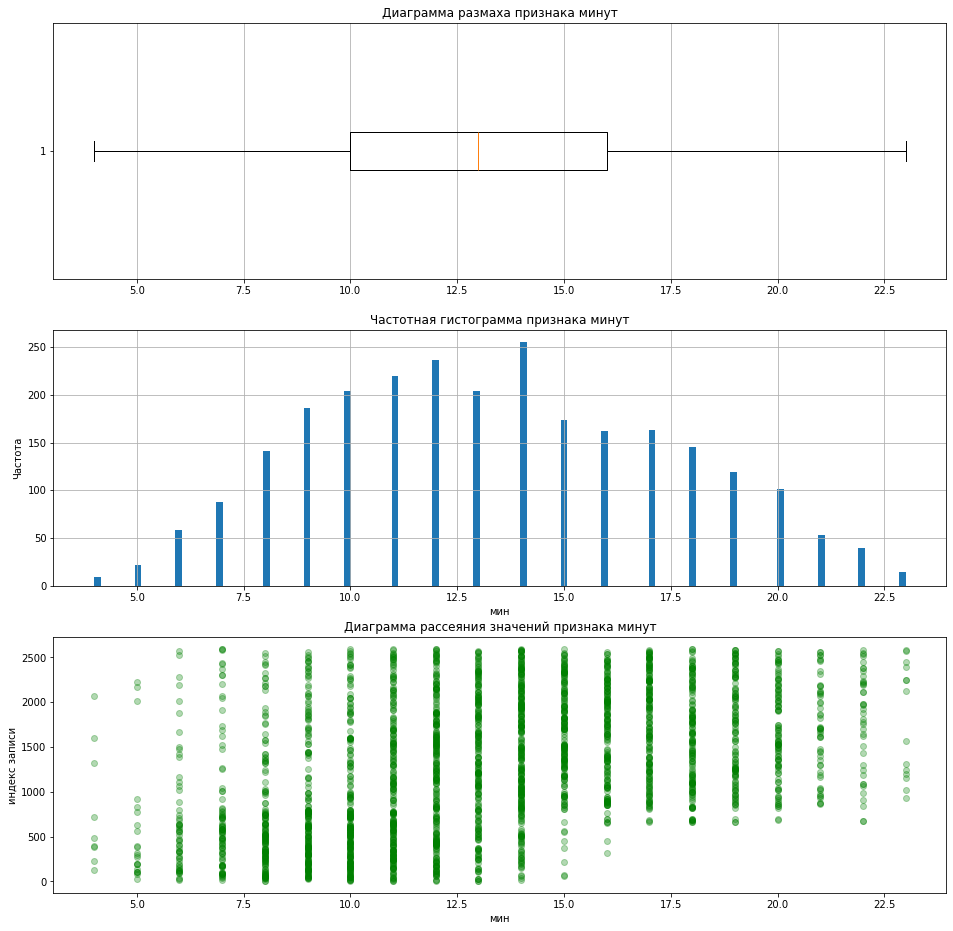

In [55]:
chart_attribute(data_time_минут, 'минут', 'мин',  120)

In [56]:
Anderson(data_time_минут)

Статистика теста: 13.7920
Критическое значение для 5% уровня значимости: 0.7860
Отклоняем H0: распределение НЕ нормальное (p < 0.05)


### Набор данных dataset_market_time, трансформация признака 'минут'

In [57]:
dataset_market_time = dataset_market_time.pivot(index='id', columns='период', values='минут')
dataset_market_time = dataset_market_time.add_prefix('минут_')

In [58]:
dataset_market_time.sample(5)

период,минут_предыдущий_месяц,минут_текущий_месяц
id,,
215627,8,6
216367,19,17
216422,15,17
216334,15,17
215376,8,9


**Присутствие покупателей на сайте за предыдущий месяц**

In [ ]:
chart_attribute(dataset_market_time['минут_предыдущий_месяц'], 'минут-предыдущий_месяц', 'мин',  120)

In [ ]:
Anderson(dataset_market_time['минут_предыдущий_месяц'])

**Присутствие покупателей на сайте за текущий месяц**

In [ ]:
chart_attribute(dataset_market_time['минут_текущий_месяц'], 'минут-текущий_месяц', 'мин',  120)

In [ ]:
Anderson(dataset_market_time['минут_текущий_месяц'])

### Набор данных dataset_money, признак 'прибыль'

Рассмотрим спектр значений признака.

In [ ]:
data_прибыль = dataset_money['прибыль']
data_прибыль.describe()

Признак - численный.

In [ ]:
data_прибыль.nunique()

В спектре значений 399 уникальных величин.

Представим распределение в виде диаграммы размаха и гистограммы.

In [ ]:
chart_attribute(data_прибыль, 'прибыль', 'усл. ед',  120)

Протестируем распределение значений признака, тестом Андерсона-Дарлинга. Выдвинем гипотезу Н0, о нормальности распределения.

In [ ]:
Anderson(data_прибыль)

Распределение значений признака - нормальное.

## Объединение таблиц

Последовательно объединим наборы данных dataset_market, dataset_market_money и dataset_market_time, ключом объединения будем использовать идентификатор покупателя, а принцип объединения - полное внутренние совпадение.

### Объединение наборов данных dataset_market и dataset_market_money

In [59]:
dataset_market = pd.merge(dataset_market, dataset_market_money, how = 'inner', on = 'id')
dataset_market.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 0 to 1295
Data columns (total 16 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int64  
 1   покупательская_активность            1296 non-null   object 
 2   тип_сервиса                          1296 non-null   object 
 3   разрешить_сообщать                   1296 non-null   object 
 4   маркет_актив_6_мес                   1296 non-null   float64
 5   маркет_актив_тек_мес                 1296 non-null   int64  
 6   длительность                         1296 non-null   int64  
 7   акционные_покупки                    1296 non-null   float64
 8   популярная_категория                 1296 non-null   object 
 9   средний_просмотр_категорий_за_визит  1296 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 11  ошибка_сервиса                

### Объединение наборов данных dataset_market и dataset_market_time

In [60]:
dataset_market = pd.merge(dataset_market, dataset_market_time, how = 'inner', on = 'id')
dataset_market.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 0 to 1295
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int64  
 1   покупательская_активность            1296 non-null   object 
 2   тип_сервиса                          1296 non-null   object 
 3   разрешить_сообщать                   1296 non-null   object 
 4   маркет_актив_6_мес                   1296 non-null   float64
 5   маркет_актив_тек_мес                 1296 non-null   int64  
 6   длительность                         1296 non-null   int64  
 7   акционные_покупки                    1296 non-null   float64
 8   популярная_категория                 1296 non-null   object 
 9   средний_просмотр_категорий_за_визит  1296 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 11  ошибка_сервиса                

### Объединение наборов данных dataset_market и dataset_money

In [61]:
dataset_market = pd.merge(dataset_market, dataset_money, how = 'inner', on = 'id')
dataset_market.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 0 to 1295
Data columns (total 19 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int64  
 1   покупательская_активность            1296 non-null   object 
 2   тип_сервиса                          1296 non-null   object 
 3   разрешить_сообщать                   1296 non-null   object 
 4   маркет_актив_6_мес                   1296 non-null   float64
 5   маркет_актив_тек_мес                 1296 non-null   int64  
 6   длительность                         1296 non-null   int64  
 7   акционные_покупки                    1296 non-null   float64
 8   популярная_категория                 1296 non-null   object 
 9   средний_просмотр_категорий_за_визит  1296 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 11  ошибка_сервиса                

### Обзор подготовленного набора данных dataset_market

В итоге, назначем идентификатор покупателя 'id', индексом набора данных и выведем пятистрочный сэмпл данных.

In [62]:
dataset_market = dataset_market.set_index('id')
dataset_market.sample(5)

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,прибыль
id,,,,,,,,,,,,,,,,,,
215674,Снизилась,стандарт,да,3.00,4,304,0.25,Домашний текстиль,1,6,5,3,"4,789.50","4,305.00","4,762.20",11,11,2.72
216536,Прежний уровень,стандарт,нет,5.20,3,324,0.15,Товары для детей,6,1,4,10,"5,109.00","4,949.00","5,097.30",10,13,3.35
215763,Прежний уровень,стандарт,нет,3.70,3,300,0.23,Мелкая бытовая техника и электроника,3,3,4,4,"6,219.50","5,228.00","7,208.80",12,14,2.43
216213,Прежний уровень,стандарт,да,3.30,4,410,0.13,Домашний текстиль,6,2,8,11,"5,118.50","4,835.00","5,494.20",15,16,2.36
216305,Прежний уровень,премиум,нет,4.90,4,508,0.14,Косметика и аксесуары,2,1,6,8,"5,621.00","4,679.00","6,567.40",17,18,5.34


In [289]:
dataset_market.sample(5)

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,прибыль
id,,,,,,,,,,,,,,,,,,
215363,Снизилась,стандарт,нет,4.90,4,923,0.29,Товары для детей,6,0,3,1,"6,010.00","4,633.00","6,128.30",8,5,1.83
216324,Прежний уровень,премиум,да,4.30,5,509,0.25,Мелкая бытовая техника и электроника,3,5,4,9,"4,852.50","4,473.00","5,311.40",19,20,0.86
215973,Прежний уровень,стандарт,нет,3.90,4,980,0.15,Мелкая бытовая техника и электроника,2,1,7,4,"3,986.00","4,925.00","3,302.20",17,16,3.54
216520,Прежний уровень,стандарт,да,4.10,4,644,0.21,Кухонная посуда,2,3,6,10,"4,532.50","4,870.00","4,370.00",21,15,3.42
216250,Прежний уровень,стандарт,да,4.40,5,869,0.13,Кухонная посуда,5,1,8,16,"5,068.50","4,377.00","5,797.80",19,15,2.24


Объединение наборов данных завершено.

## Корреляционный анализ

### Расчёт коэффициентов  $\phi_{K}$ корреляции

In [63]:
intervals_columns = dataset_market.drop('прибыль', axis = 1).select_dtypes('number').columns.tolist()
phik_overview = dataset_market.drop('прибыль', axis = 1).phik_matrix(interval_cols = intervals_columns)
display(phik_overview)

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
покупательская_активность,1.00,0.13,0.00,0.54,0.00,0.10,0.51,0.30,0.54,0.51,0.22,0.75,0.22,0.50,0.20,0.69,0.58
тип_сервиса,0.13,1.00,0.29,0.09,0.05,0.40,0.03,0.07,0.19,0.12,0.08,0.10,0.00,0.07,0.12,0.13,0.00
разрешить_сообщать,0.00,0.29,1.00,0.00,0.05,0.25,0.01,0.07,0.07,0.20,0.02,0.04,0.08,0.00,0.06,0.04,0.00
маркет_актив_6_мес,0.54,0.09,0.00,1.00,0.08,0.00,0.28,0.15,0.21,0.29,0.14,0.40,0.16,0.32,0.04,0.36,0.33
маркет_актив_тек_мес,0.00,0.05,0.05,0.08,1.00,0.17,0.00,0.14,0.25,0.14,0.12,0.00,0.05,0.00,0.00,0.11,0.06
длительность,0.10,0.40,0.25,0.00,0.17,1.00,0.00,0.00,0.19,0.19,0.18,0.12,0.13,0.11,0.15,0.03,0.10
акционные_покупки,0.51,0.03,0.01,0.28,0.00,0.00,1.00,0.12,0.20,0.24,0.00,0.31,0.06,0.23,0.07,0.26,0.25
популярная_категория,0.30,0.07,0.07,0.15,0.14,0.00,0.12,1.00,0.23,0.25,0.00,0.16,0.25,0.04,0.24,0.20,0.09
средний_просмотр_категорий_за_визит,0.54,0.19,0.07,0.21,0.25,0.19,0.20,0.23,1.00,0.33,0.07,0.26,0.10,0.18,0.09,0.16,0.18
неоплаченные_продукты_штук_квартал,0.51,0.12,0.20,0.29,0.14,0.19,0.24,0.25,0.33,1.00,0.03,0.36,0.25,0.26,0.23,0.26,0.23


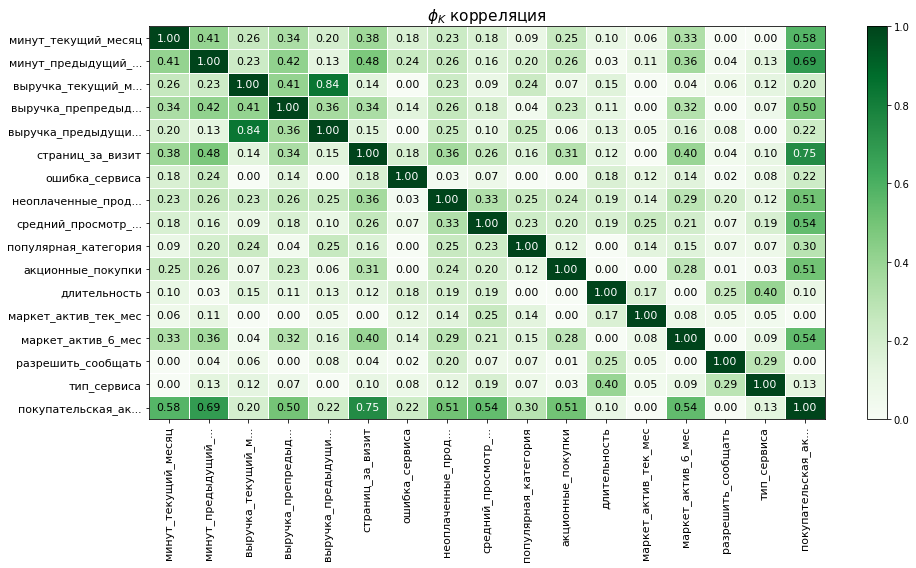

In [64]:
plot_correlation_matrix(phik_overview.values, x_labels = phik_overview.columns, y_labels = phik_overview.index,\
                        vmin = 0, vmax = 1, color_map = 'Greens', title = r'$\phi_{K}$ корреляция', fontsize_factor = 1.1,\
                        figsize = (14, 8))

Наиболее сильная взаимная корреляция наблюдается между признаками 'выручка_предыдущий_месяц' и 'выручка_текущий_месяц'. Значение коэффициента ФиК корреляции - 0.84. Можно считать, мультиколлениарность ниже значения 0.90 - умеренная.

### Расчёт VIF величин

In [65]:
vif_scores = get_vif_scores(dataset_market[intervals_columns])
display(vif_scores)

,Признак,VIF
9,выручка_предыдущий_месяц,4.26
11,выручка_текущий_месяц,3.90
10,выручка_препредыдущий_месяц,1.61
12,минут_предыдущий_месяц,1.53
8,страниц_за_визит,1.42
13,минут_текущий_месяц,1.32
1,маркет_актив_6_мес,1.22
6,неоплаченные_продукты_штук_квартал,1.20
4,акционные_покупки,1.19
5,средний_просмотр_категорий_за_визит,1.18


Мультиколлениарность слабая, почти все величины лежат в диапазоне от 1 до 2.

Выделяются те же признаки: 'выручка_предыдущий_месяц' и 'выручка_текущий_месяц'. Значения близки к 5, хотя и ниже.

Величин выше 5 - нет. То есть, можно утведждать, что признаков с сильной мультиколлениарностью - нет.

### Ранжирование признаков по статистическому влиянию на целевой признак

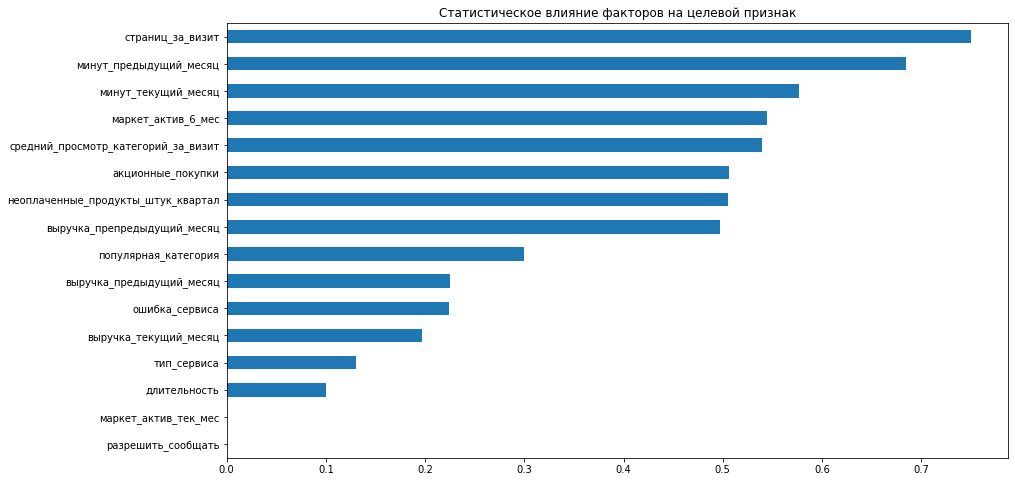

In [66]:
plt.figure(figsize = (14, 8))
plt.title('Статистическое влияние факторов на целевой признак')
plt.grid(visible = True, axis = 'x')
phik_overview['покупательская_активность'].sort_values(ascending = True)[:-1].plot(kind = 'barh')
plt.show()

Признаки 'разрешить_сообщать' и 'маркет_актив_тек_мес' практически не имеют статистического влияния на целевой признак.

## Использование пайплайнов

### Деление набора данных на тренировочную и тестовую выборки

Разделим набор данных на тренировочную и тестовую выборки. Из тренировочных данных удалим целевой признак 'покупательская_активность' и ненужный в машинном обучении признак 'прибыль'. Идентификатор клиента 'id' мы уже назначили индексом в наборе данных.

In [455]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset_market.drop(['покупательская_активность', 'прибыль'], axis = 1),
    dataset_market['покупательская_активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = dataset_market['покупательская_активность'])

In [459]:
type(y_train)

pandas.core.series.Series

### Кодирование целевого признака в тренировочной и тестовой выборках

Для автоматического кодирования текстовых значений целевого признака, применим LabelEncoder.

In [68]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

Выведем результат кодирования. Соответствие цифровых и текстовых значений целевого признака.

In [69]:
pred_classes = np.unique(y_test)
print('Значения признака до кодирования: ', pred_classes)
print('Значения признака после кодирования: ', label_encoder.inverse_transform(pred_classes))

Значения признака до кодирования:  [0 1]
Значения признака после кодирования:  ['Прежний уровень' 'Снизилась']


### Распределение признаков по автоматическим операциям кодирования и масштабирования

Явное разделим признаки по типам кодирования и масштабирования.

In [70]:
# признаки для кодирования OneHotEncoder
ohe_columns = [
    'популярная_категория',
    'разрешить_сообщать'
]

# признаки для кодирования OrdinalEncoder
ord_columns = [
    'тип_сервиса' 
]

# признаки для масштабирования
num_columns = [
    'средний_просмотр_категорий_за_визит',
    'акционные_покупки',
    'неоплаченные_продукты_штук_квартал',
    'ошибка_сервиса',
    'маркет_актив_6_мес',
    'маркет_актив_тек_мес',
    'длительность',
    'страниц_за_визит',
    'выручка_препредыдущий_месяц',
    'выручка_текущий_месяц',
    'выручка_предыдущий_месяц',
    'минут_текущий_месяц',
    'минут_предыдущий_месяц'
]

### Конструирование пайплайнов-компонентов

Пайплайн one_hot кодирования категориальных данных.

In [372]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')),
     ('ohe', OneHotEncoder(drop = 'first', handle_unknown='error', sparse_output = False))
    ])

Пайплайн порядкового кодирования категориальных данных.

In [373]:
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')),
     ('ord',  OrdinalEncoder(categories = [['стандарт', 'премиум']], handle_unknown = 'use_encoded_value',\
                             unknown_value = np.nan)),
     ('simpleImputer_after_ord', SimpleImputer(missing_values = np.nan, strategy = 'most_frequent'))
    ])

Пайплайн-трансформер препроцессинга данных.

In [374]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough')

Пайплайн-коллектор данных.

In [375]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    #('feature_selection', SelectFromModel(RandomForestClassifier(n_estimators = 10))),
    ('models', DecisionTreeClassifier(random_state = RANDOM_STATE))
])

In [376]:
pipe_final.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['популярная_категория',
                                                   'разрешить_сообщать']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strateg...
                                                  ['средний_просмотр_категорий_за_визит',
                                                   'акционные_покупки',
                                                   'неоплаченные_продукты_штук_квартал',
                                                   'ошибка_сервиса',
                                                   'маркет_актив_6_мес',
                                                   'маркет_актив_тек_мес',
                                                   'длительность',
                                                   'страниц_за_визит',
                                                   'выручка_препредыдущий_месяц',
                                                   'выручка_текущий_месяц',
                                                   'выручка_предыдущий_месяц',
                                                   'минут_текущий_месяц',
                                                   'минут_предыдущий_месяц'])])),
                ('models', DecisionTreeClassifier(random_state=27466437))])

Конструкция собрана.

### Перебор гиперпараметров через случайный кросс-валидатор

Используем четыре модели линейной классификации:
 - DecisionTreeClassifier - решающее дерево;
 - KNeighborsClassifier - k ближайших соседей;
 - LogisticRegression - логистическая регрессия;
 - SupportVectorClassifier - опорные вектора.

Составим список из четырёх словарей, по словарю на модель. В словарях, в виде пары ключ-значение, перечислим гиперпараметры моделей.

In [377]:
param_grid = [
    # словарь для модели LogisticRegressionClassifier
    {
        'preprocessor__num': [MinMaxScaler(), RobustScaler(), StandardScaler(), 'passthrough'],
        #'feature_selection__estimator__max_depth': [3, 5],
        #'feature_selection__threshold': ['mean', 'median'],
        'models': [LogisticRegression(
            random_state = RANDOM_STATE,
            solver = 'liblinear',
            penalty = 'l1',
            class_weight = 'balanced'
        )],
        'models__C': [0.01, 0.1, 1, 10],
        'models__max_iter': [1000, 2000, 3000]
    },
    
    # словарь для модели SupportVectorClassifier
    {
        'preprocessor__num': [MinMaxScaler(), RobustScaler(), StandardScaler(), 'passthrough'],
        #'feature_selection__estimator__max_depth': [3, 5],
        #'feature_selection__threshold': ['mean', 'median'],
        'models': [SVC(
            kernel = 'poly',
            random_state = RANDOM_STATE,
            gamma = 'auto',
            probability = True,
            class_weight = 'balanced'
        )],
        'models__degree': range(2, 8),
        'models__C': [0.01, 0.1, 1, 10]
    },

    # словарь для модели DecisionTreeClassifier
    {
        'preprocessor__num': [MinMaxScaler(), RobustScaler(), StandardScaler(), 'passthrough'],
        #'feature_selection__estimator__max_depth': [3, 5],
        #'feature_selection__threshold': ['mean', 'median'],
        'models': [DecisionTreeClassifier(random_state = RANDOM_STATE)],
        'models__max_depth': range(1, 20),
        'models__max_features': range(1, 20),
        'models__min_samples_split': range(2, 10)
    },
    
    # словарь для модели KNeighborsClassifier 
    {
        'preprocessor__num': [MinMaxScaler(), RobustScaler(), StandardScaler(), 'passthrough'],
        #'feature_selection__estimator__max_depth': [3, 5],
        #'feature_selection__threshold': ['mean', 'median'],
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 20)
    }
]

Составим словарь из метрик, по которым будет оцениваться качество моделей в кросс-валидаторе. Используем метрику Recall, как показатель минимизации ложно-отрицательных прогнозов, среднее гармоническое F1 между Recall и Precission и ROC-AUC, как показатель уверенности разделения классов.

Если, в итоге, модель будет уверенно разделять клиентов интернет-магазина на лояльных и нелояльных, но будет часто незамечать клиентов склонных к снижению покупательской активности, ложно классифицируя их как клиентов с прежней активностью, то ценность модели с точки зрения бизнеса будет под большим вопросом.

In [441]:
scoring = {
    'recall': make_scorer(recall_score, pos_label = 1),
    'roc_auc': 'roc_auc',
}

Итак, создадим объект модели случайного кросс-валидатора RandomizedSearchCV и инициализируем его пайплайном-коллектором данных pipe_final, списком гиперпараметров param_grid и списком метрик scoring. Запустим объект randomized_search, методом fit на поиск лучшего сочетания модель/гиперпараметры. В качестве финальной оценки результата, используем метрику roc_auc.

Поиск занимает больше двух минут.

In [442]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid,
    verbose = 2,
    n_iter = 400,
    random_state = RANDOM_STATE,
    refit = 'recall',
    cv = 5,
    scoring = scoring,
    n_jobs = -1
)
randomized_search.fit(X_train, y_train)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
[CV] END models=DecisionTreeClassifier(random_state=27466437), models__max_depth=12, models__max_features=6, models__min_samples_split=6, preprocessor__num=RobustScaler(); total time=   0.0s
[CV] END models=DecisionTreeClassifier(random_state=27466437), models__max_depth=12, models__max_features=6, models__min_samples_split=6, preprocessor__num=RobustScaler(); total time=   0.0s
[CV] END models=DecisionTreeClassifier(random_state=27466437), models__max_depth=12, models__max_features=6, models__min_samples_split=6, preprocessor__num=RobustScaler(); total time=   0.0s
[CV] END models=DecisionTreeClassifier(random_state=27466437), models__max_depth=12, models__max_features=6, models__min_samples_split=6, preprocessor__num=RobustScaler(); total time=   0.0s
[CV] END models=DecisionTreeClassifier(random_state=27466437), models__max_depth=12, models__max_features=6, models__min_samples_split=6, preprocessor__num=RobustScaler(); 

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              sparse_output=False))]),
                                                                               ['популярная_категория',
                                                                                'разрешить_сообщать']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simpleImputer...
                                                               RobustScaler(),
                                                               StandardScaler(),
                                                               'passthrough']},
                                        {'models': [KNeighborsClassifier()],
                                         'models__n_neighbors': range(2, 20),
                                         'preprocessor__num': [MinMaxScaler(),
                                                               RobustScaler(),
                                                               StandardScaler(),
                                                               'passthrough']}],
                   random_state=27466437, refit='recall',
                   scoring={'recall': make_scorer(recall_score, response_method='predict', pos_label=1),
                            'roc_auc': 'roc_auc'},
                   verbose=2)

Результаты перебора гиперпараметров кросс-валидатором.

In [454]:
best_model_pipeline = randomized_search.best_estimator_
best_model_params = randomized_search.best_params_
best_model_score = randomized_search.best_score_
y_test_pred = randomized_search.predict(X_test)
y_test_proba = randomized_search.predict_proba(X_test)[:, 1]
train_score = randomized_search.score(X_train, y_train)
test_score = randomized_search.score(X_test, y_test)

#selected_features = best_model_pipeline.named_steps['preprocessor'].get_feature_names_out()[best_model_pipeline.\
#                                                                        named_steps['feature_selection'].get_support()]

print('Лучшие параметры:\n', best_model_params)
print(f'refit метрика: {randomized_search.refit}')      
print (f'Лучшая точность на кросс-валидации: {best_model_score:.4f}')
print('************************************************')
print(f'Точность на тренировочных данных: {train_score:.4f}')
print(f'Точность на тестовых данных: {test_score:.4f}')
print(f'Accuracy на тестовых данных: {accuracy_score(y_test, y_test_pred):.4f}')
print(f'Recall на тренировочных данных: {recall_score(y_train, randomized_search.predict(X_train)):.4f}')
print(f'Recall на тестовых данных: {recall_score(y_test, y_test_pred):.4f}')
print(f'ROC-AUC на тестовых данных: {roc_auc_score(y_test, y_test_proba):.4f}')
#print('************************************************')
#print(f"Выбранные признаки: {selected_features}")

Лучшие параметры:
 {'preprocessor__num': MinMaxScaler(), 'models__max_iter': 2000, 'models__C': 1, 'models': LogisticRegression(class_weight='balanced', penalty='l1', random_state=27466437,
                   solver='liblinear')}
refit метрика: recall
Лучшая точность на кросс-валидации: 0.8034
************************************************
Точность на тренировочных данных: 0.8005
Точность на тестовых данных: 0.8130
Accuracy на тестовых данных: 0.8642
Recall на тренировочных данных: 0.8005
Recall на тестовых данных: 0.8130
ROC-AUC на тестовых данных: 0.9140


### Обзор параметров лучшей подобранной модели классификации

Лучшие линейные модели, их рейтинги и метрики в кросс-валидаторе.

In [449]:
results = pd.DataFrame(randomized_search.cv_results_)
results['модель'] = results['param_models'].apply(lambda x: x.__class__.__name__)
detailed_names = {
    'mean_score_time': 'время_предсказания',
    'mean_test_recall': 'метрика_recall_на_кроссвалидации',
    'rank_test_recall': 'место_по_метрике_recall',
    'mean_test_roc_auc': 'метрика_roc_auc_на_кроссвалидации',
    'rank_test_roc_auc': 'место_по_метрике_roc_auc'
}
results_renamed = results.rename(columns = detailed_names)
best_models = results_renamed.sort_values('место_по_метрике_roc_auc').groupby('модель').first() #.reset_index()
display(best_models[['время_предсказания',\
                     'место_по_метрике_roc_auc',\
                     'место_по_метрике_recall',\
                     'метрика_roc_auc_на_кроссвалидации',\
                     'метрика_recall_на_кроссвалидации']])

,время_предсказания,место_по_метрике_roc_auc,место_по_метрике_recall,метрика_roc_auc_на_кроссвалидации,метрика_recall_на_кроссвалидации
модель,,,,,
DecisionTreeClassifier,0.02,4,104,0.87,0.74
KNeighborsClassifier,0.03,3,381,0.87,0.60
LogisticRegression,0.03,1,1,0.90,0.80


Результат перебора:
 - лучший классификатор - Логистическая регрессия с балансировкой весов классификации и LASSO регуляризацией;
 - лучший препроцессор - Масштабатор по минимальным/максимальным значениям.

### Ручная регулировка метрики Recall лучшей модели

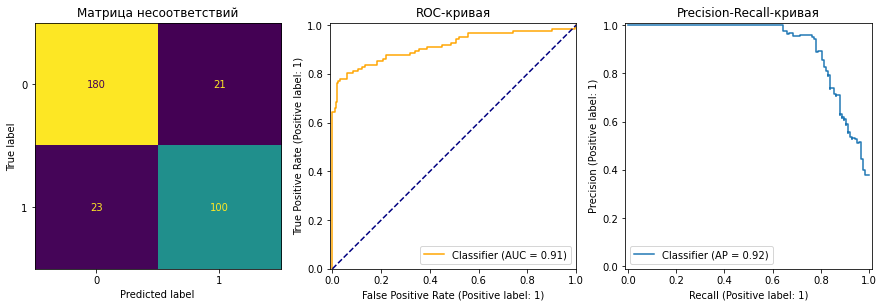

              precision    recall  f1-score   support

           0       0.89      0.90      0.89       201
           1       0.83      0.81      0.82       123

    accuracy                           0.86       324
   macro avg       0.86      0.85      0.86       324
weighted avg       0.86      0.86      0.86       324



In [450]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

ConfusionMatrixDisplay.from_predictions(
    y_test, y_test_pred,
    ax = axes[0],
    colorbar = False,
)
axes[0].set(title = 'Матрица несоответствий')

RocCurveDisplay.from_predictions(
    y_test, y_test_proba,
    ax = axes[1],
    color = 'orange',
)
axes[1].plot([0, 1], [0, 1], color = 'navy', linestyle = '--')
axes[1].set(title = 'ROC-кривая', xlim = (-0.01, 1), ylim = (0, 1.01))

PrecisionRecallDisplay.from_predictions(
    y_test, y_test_proba,
    ax = axes[2],
)
axes[2].set(title = 'Precision-Recall-кривая')

plt.show()

print(classification_report(y_test, y_test_pred))

Реально увеличить значение метрики Recall, но за счёт снижения метрик Accuracy и Precision. Найдём порог, где Recall больше либо 0.9, а Precision всё ещё не ниже 0.5.

In [451]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_test_proba)
idx = np.where((recalls[:-1] >= 0.9) & (precisions[:-1] >= 0.5))[0][-1]
optimal_threshold = thresholds[idx]
print('Оптимальный порог вероятности: {0:.5f}'.format(optimal_threshold))
print('Соответствующая порогу метрика Recall: {0:.2f}'.format(recalls[idx]))
print('Соответствующая порогу метрика Precision: {0:.2f}'.format(precisions[idx]))
# Применяем порог
y_test_pred = (y_test_proba >= optimal_threshold).astype(int)

Оптимальный порог вероятности: 0.24092
Соответствующая порогу метрика Recall: 0.90
Соответствующая порогу метрика Precision: 0.61


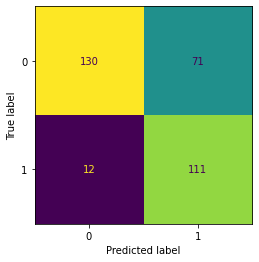

              precision    recall  f1-score   support

           0       0.92      0.65      0.76       201
           1       0.61      0.90      0.73       123

    accuracy                           0.74       324
   macro avg       0.76      0.77      0.74       324
weighted avg       0.80      0.74      0.75       324



In [452]:
ConfusionMatrixDisplay.from_predictions(
    y_test, y_test_pred,
    colorbar = False,
)
plt.show()
print(classification_report(y_test, y_test_pred))

Как видим, понижая порог вероятности, гораздо быстрее растёт количество ложно-положительных прогнозов, чем снижается количество ложно-отрицательных. Думаю, что снижать порог вероятности классификации даже до уровня 0.24 - неразумно. Всё таки, решение где дополнительные 50 покупателей ошибочно идентифицированых, как 'теряющих лояльность', взамен 11 дополнительных покупателей с реальным снижением лояльности, замеченных системой, может быть неприемлимым. Решение за заказчиком.

## Анализ важности признаков

### Выделение обработанных значений признаков и лучшей обученной модели из случайного кросс-валидатора

In [389]:
fitted_model = best_model_pipeline.named_steps['models']
fitted_preprocessor = best_model_pipeline.named_steps['preprocessor']
feature_names = fitted_preprocessor.get_feature_names_out()
X_train_transformed = fitted_preprocessor.transform(X_train)
X_test_transformed = fitted_preprocessor.transform(X_test)
X_train_preprocessed = pd.DataFrame(X_train_transformed, columns = feature_names)
X_test_preprocessed = pd.DataFrame(X_test_transformed, columns = feature_names)
X_train_preprocessed.sample(5)

,ohe__популярная_категория_Косметика и аксесуары,ohe__популярная_категория_Кухонная посуда,ohe__популярная_категория_Мелкая бытовая техника и электроника,ohe__популярная_категория_Техника для красоты и здоровья,ohe__популярная_категория_Товары для детей,ohe__разрешить_сообщать_нет,ord__тип_сервиса,num__средний_просмотр_категорий_за_визит,num__акционные_покупки,num__неоплаченные_продукты_штук_квартал,num__ошибка_сервиса,num__маркет_актив_6_мес,num__маркет_актив_тек_мес,num__длительность,num__страниц_за_визит,num__выручка_препредыдущий_месяц,num__выручка_текущий_месяц,num__выручка_предыдущий_месяц,num__минут_текущий_месяц,num__минут_предыдущий_месяц
52,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.22,0.50,0.44,0.44,0.50,0.09,0.68,0.51,0.18,0.32,0.53,0.89
450,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.80,0.06,0.10,0.78,0.84,0.50,0.93,0.42,0.43,0.63,0.61,0.32,0.28
435,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.40,0.15,0.50,0.44,0.61,1.00,0.50,0.74,0.43,0.41,0.37,0.63,0.67
688,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.40,0.91,0.00,0.33,0.81,0.50,0.94,0.53,0.63,0.66,0.67,0.11,0.44
152,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.20,0.07,0.30,0.78,0.91,0.00,0.98,0.37,0.78,0.33,0.47,0.68,0.56


### Оценка коэффициентов обученной модели при признаках

<Axes: ylabel='Feature'>

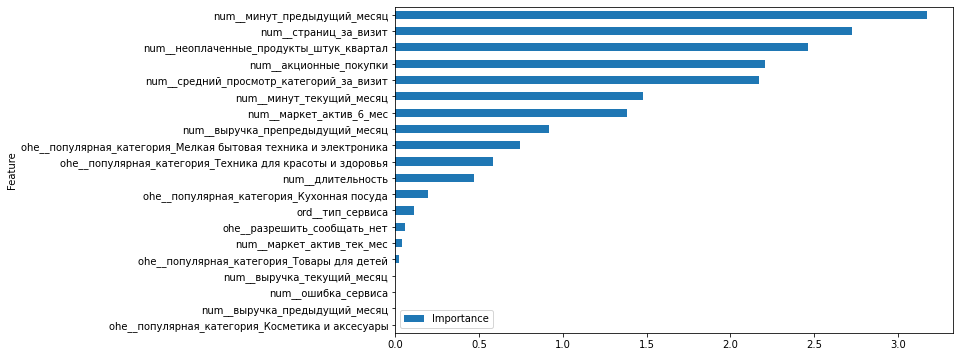

In [390]:
coefficients = fitted_model.coef_[0]
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending = True)
feature_importance.plot(x = 'Feature', y = 'Importance', kind = 'barh', figsize = (10, 6))

Наиболее влияющие коэффициенты при следующих признаках:
 - минут_предыдущий_месяц
 - страниц_за_визит
 - неоплаченные_продукты_штук_квартал
 - акционные_покупки
 - средний_просмотр_категорий_за_визит

### Анализ SHAP значений

In [391]:
explainer = shap.LinearExplainer(fitted_model, X_train_preprocessed, feature_perturbation = 'correlation_dependent')
shap_values = explainer(X_test_preprocessed)

Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

Построим диаграмму общих вкладов признаков в прогноз модели.

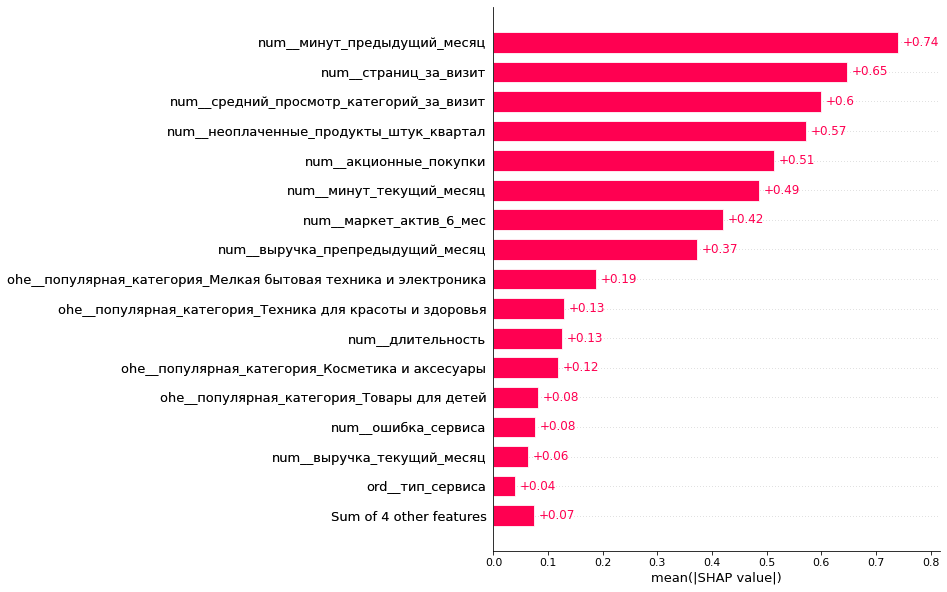

In [392]:
shap.plots.bar(shap_values, max_display=17)

Восемь верхних признаков имеют выраженно большее абсолютное влияние на прогнозы модели:
 - минут_предыдущий_месяц
 - страниц_за_визит
 - средний_просмотр_категорий_за_визит
 - неоплаченные_продукты_штук_квартал
 - акционные_покупки
 - присутствие_минут_текущий_месяц
 - маркет_актив\_6\_мес
 - выручка_препредыдущий_месяц
 
 

Построим график влияния признаков на прогноз классификации модели.

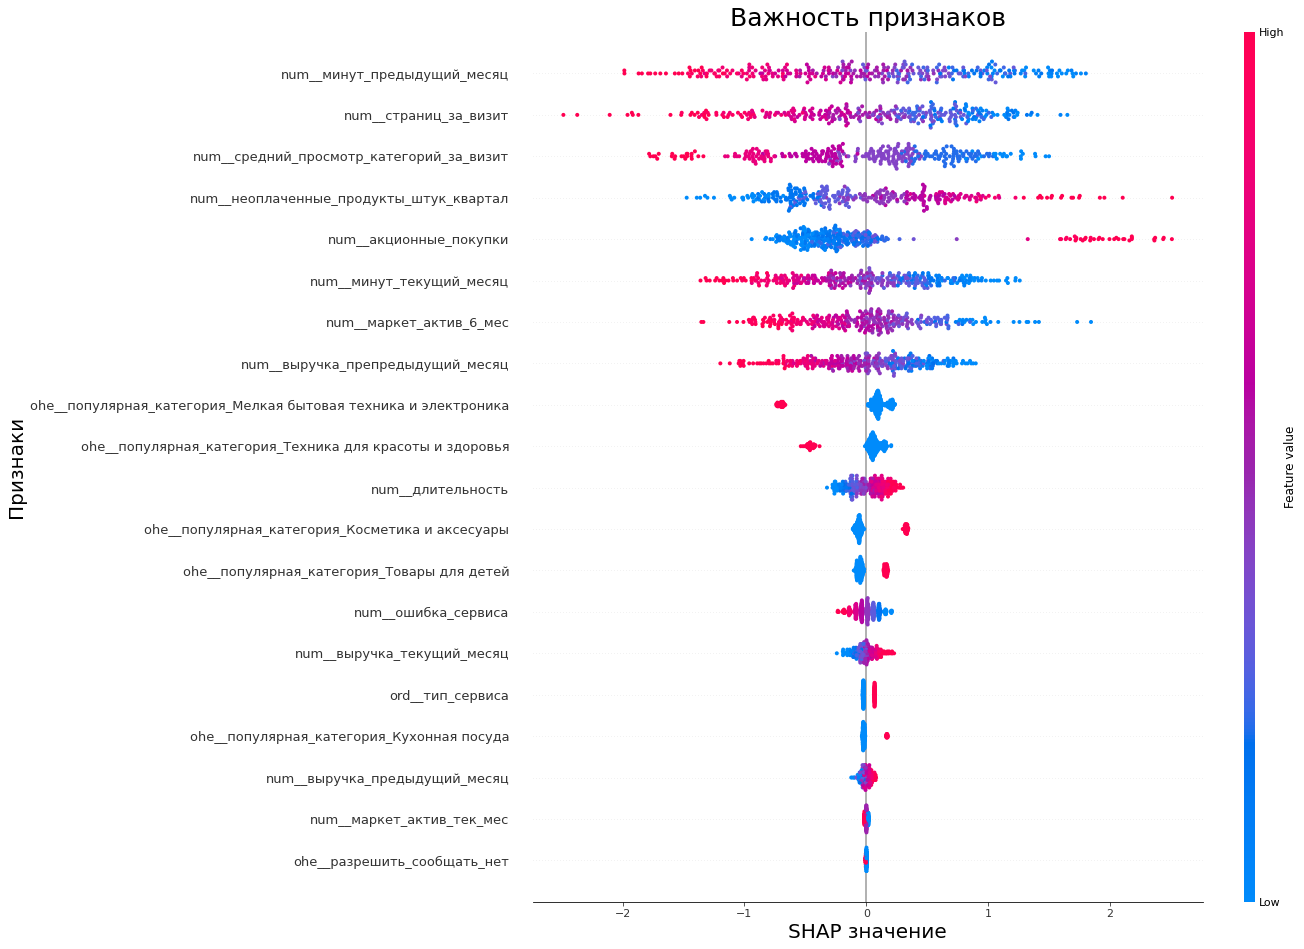

In [393]:
shap.plots.beeswarm(
    shap_values,
    plot_size=(17, 17),
    max_display=30,
    show=False   
)
plt.title('Важность признаков', fontsize=25)
plt.xlabel('SHAP значение', fontsize=20)
plt.ylabel('Признаки', fontsize=20)
plt.gcf().set_size_inches(15, 16) 
plt.show()

Напомним себе, что наименование класса "снизилась" - это наша целевая группа покупателей, которая теряет активность.

Очевидно, что только часть признаков обладающих влиянием на прогноз модели может поддаваться прямому воздействию.
 - неоплаченные_продукты_штук_квартал - высокие количества неоплаченых товаров в корзине, мощно склоняют модель к классификации 'снизилась';
 - акционные_покупки - высокая доля в покупках акционных товаров, мощно склоняет модель к классификации 'снизилась';
 - маркет_актив\_6\_мес - низкое количество контактов с покупателем в течении полугода, умерено склоняет модель к классификации 'снизилась'.
 
Некоторые признаки, можно использовать, как индикаторы роста вероятности снижения покупательской активности.
 - минут_предыдущий_месяц - малые количества времени проводимые покупателем в интернет-магазине в прошлом месяце, мощно склоняют модель к классификации 'снизилась';
 - страниц_за_визит - малые колличества просматриваемых покупателем страниц интернет-магазина за визит, мощно склоняют модель к классификации 'снизилась';
 - средний_просмотр_категорий_за_визит- малые колличества просматриваемых покупателем категорий товаров за визит, мощно склоняют модель к классификации 'снизилась';
 - минут_текущий_месяц - малые количества времени проводимые покупателем в интернет-магазине в текущем месяце, мощно склоняют модель к классификации 'снизилась'.

## Сегментация покупателей

Снова выделим набор значений признаков X, как в п.7.1, но без разделения на тренировочную и тестовую выборки. Используя лучшую обученную линейную модель, рассчитаем вероятности снижения активности покупателей и добавим их в набор данных dataset_market, как новый признак 'вероятность'.

In [394]:
X = dataset_market.drop(['покупательская_активность', 'прибыль'], axis=1)
dataset_market['вероятность'] = fitted_model.predict_proba(fitted_preprocessor.transform(X))[:, 1]
dataset_market.sample(5)

### Критерий сегментирования - покупательская активность

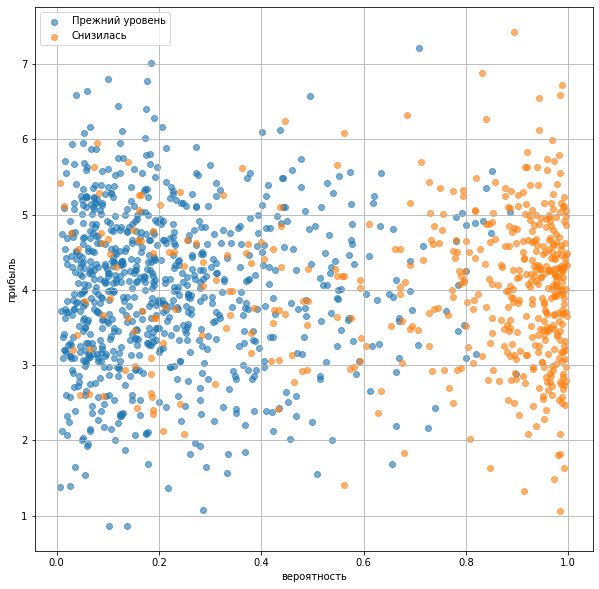

In [395]:
scatter_attr(dataset_market, 'покупательская_активность')

Модель действительно, довольно точно предсказывает класс целевого признака. На диаграмме отчётливо локализованы ядра областей значений целевого признака 'покупательская_активность':
 - для значений 'Прежний уровень', диапазон вероятностей 0.0 - 0.2;
 - для значений 'Снизилась', диапазон вероятностей 0.9 - 1.0;
 
Прибыль, для обеих категорий покупателей сохраняет нормальность распределений, как было показано в п. 4.20. 

### Критерий сегментирования - тип сервиса

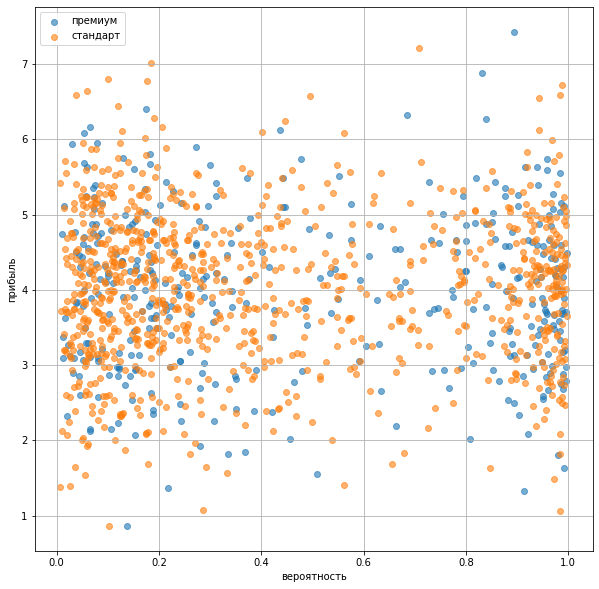

In [398]:
scatter_attr(dataset_market, 'тип_сервиса')

Как видим, значения признака Тип_сервиса хаотично перемешаны вдоль оси 'Вероятность'. Сегментирование по этому признаку бессмысленно.

### Критерий сегментирования - разрешить сообщать

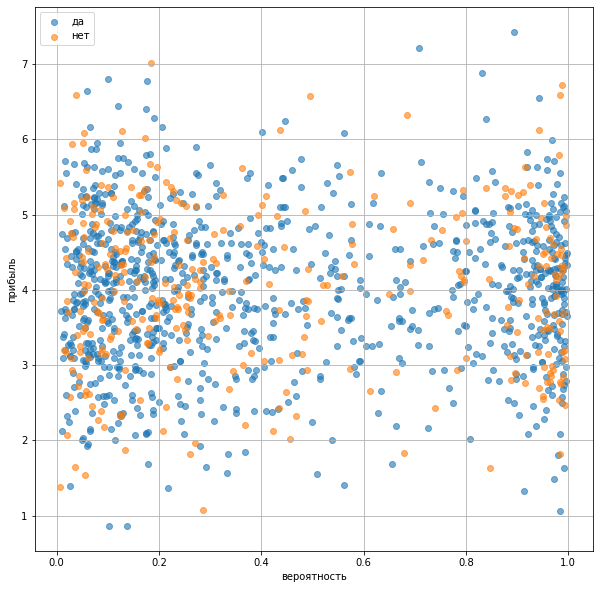

In [399]:
scatter_attr(dataset_market, 'разрешить_сообщать')

Данный признак, даже не включался в тренировочную выборку. Как ключ сегментации, этот признак бесполезен.

### Критерий сегментирования - маркет_актив\_6\_мес

Разделим спектр значений признака на три диапазона.

In [400]:
порог_1_уровень_маркет_активность = 3
порог_2_уровень_маркет_активность = 5
def level_classifier(value):
    if value < порог_1_уровень_маркет_активность:
        return 'низкий'
    elif value > порог_2_уровень_маркет_активность:
        return 'высокий'
    else:
        return 'средний'
    
dataset_market['маркет_актив_6_мес_3_кат'] = dataset_market['маркет_актив_6_мес'].\
map(level_classifier)

И уже по преобразованному признаку построим диаграмму рассеяния.

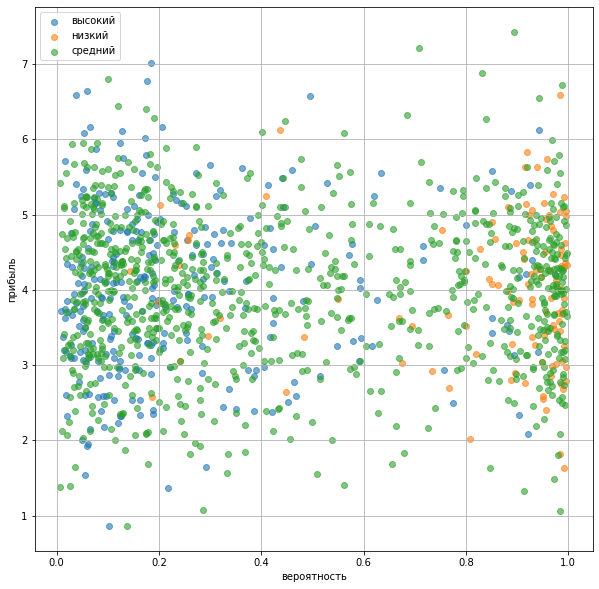

In [401]:
scatter_attr(dataset_market, 'маркет_актив_6_мес_3_кат')

Если средние значения признака распределились вдоль оси 'Вероятность', примерно равномерно, то низкие значения сконцентрировались у значений вероятностей 0.8 - 1.0.

### Критерий сегментирования - маркет_актив_тек_мес

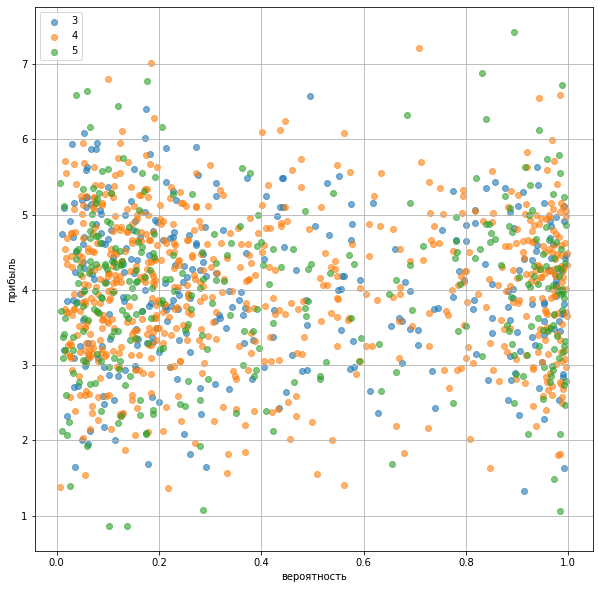

In [402]:
scatter_attr(dataset_market, 'маркет_актив_тек_мес')

Этот признак, так же не включался в тренировочную выборку, как маловлияющий. Очевидно, что по нему сегментировать покупателей невозможно.

### Критерий сегментирования - длительность

In [403]:
порог_1_уровень_длительность = 500
порог_2_уровень_длительность = 700
def level_classifier_duration(value):
    if value < порог_1_уровень_длительность:
        return 'низкая'
    elif value > порог_2_уровень_длительность:
        return 'высокая'
    else:
        return 'средняя'
    
dataset_market['длительность_3_кат'] = dataset_market['длительность'].\
map(level_classifier_duration)

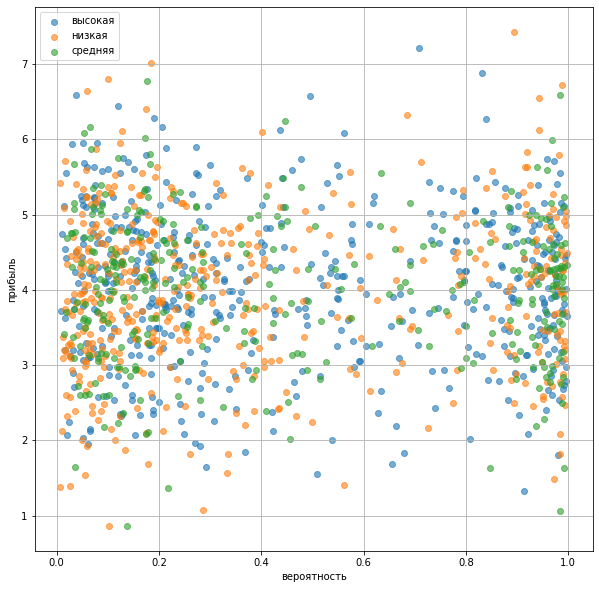

In [404]:
scatter_attr(dataset_market, 'длительность_3_кат')

Тенденции не просматриваются.

### Критерий сегментирования - акционные_покупки

Разделим значения доли акционных покупок по пороговому значению на низкий и высокий уровни.

In [405]:
порог_уровень_акционные_покупки = 0.45
dataset_market['акционные_покупки_уровень'] = dataset_market['акционные_покупки'].\
map(lambda v: 'высокий' if v >= порог_уровень_акционные_покупки else 'низкий')

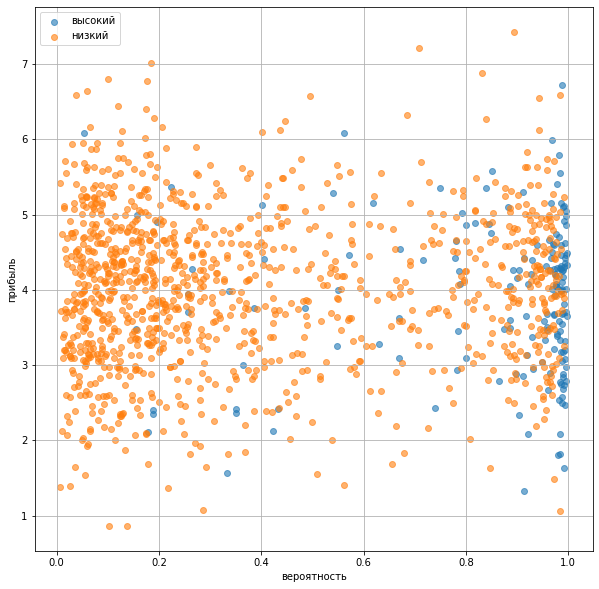

In [406]:
scatter_attr(dataset_market, 'акционные_покупки_уровень')

Отчётливо локализуются в области высоких вероятностей, покупатели с высокой долей в покупках - акционных товаров.

### Критерий сегментирования - популярная_категория

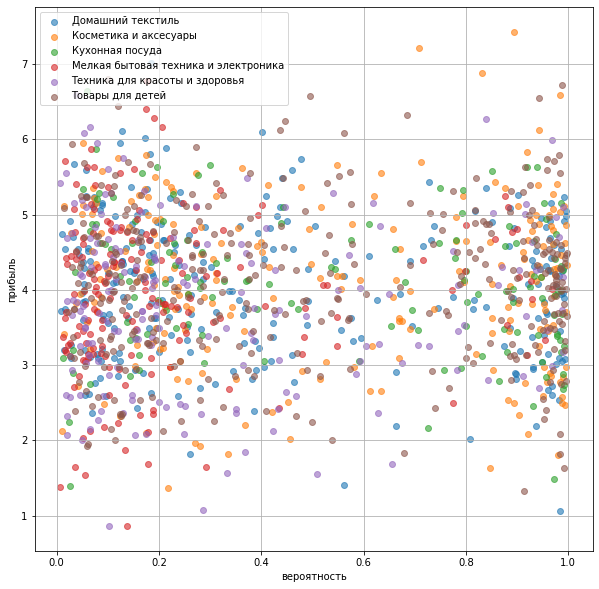

In [407]:
scatter_attr(dataset_market, 'популярная_категория')

В зоне высоких вероятностей, наблюдается низкое количество покупателей с любимой товарной категорией - 'Мелкая бытовая техника и электроника'.

### Критерий сегментирования - средний_просмотр_категорий_за_визит

In [408]:
порог_количество_категорий = 3
dataset_market['средний_просмотр_категорий_за_визит_уровень'] = dataset_market['средний_просмотр_категорий_за_визит'].\
map(lambda v: 'высокий' if v >= порог_количество_категорий else 'низкий')

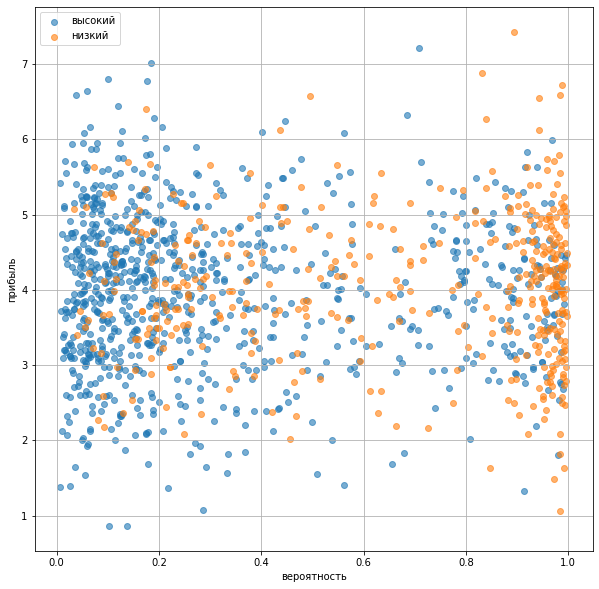

In [409]:
scatter_attr(dataset_market, 'средний_просмотр_категорий_за_визит_уровень')

Покупатели в среднем просматривающие одну или две категорий товаров за визит, явно локализуются в зоне высокой вероятности снижения покупательной активности.

### Критерий сегментирования - неоплаченные_продукты_штук_квартал

In [410]:
порог_1_уровень_неоплаченные_продукты = 6
порог_2_уровень_неоплаченные_продукты = 8
def level_classifier_undayed(value):
    if value < порог_1_уровень_неоплаченные_продукты:
        return 'низкий'
    elif value > порог_2_уровень_неоплаченные_продукты:
        return 'высокий'
    else:
        return 'средний'
    
dataset_market['неоплаченные_продукты_3_кат'] = dataset_market['неоплаченные_продукты_штук_квартал'].\
map(level_classifier_undayed)

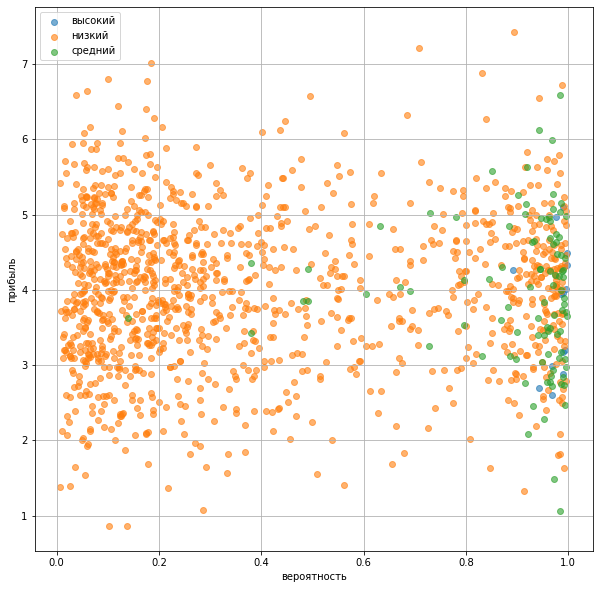

In [411]:
scatter_attr(dataset_market, 'неоплаченные_продукты_3_кат')

Тенденция не ярковыраженная, но присутствует. Пользователи за квартал набравшие от шести до десяти товаров в корзину, практически полностью локализуются в зоне высоких вероятностей. Но пользователи не имеющие в корзине неоплаченных товаров либо набравших не более пяти, распределены вдоль всей оси 'вероятность'.

### Критерий сегментирования - страниц_за_визит

In [412]:
порог_1_уровень_страниц = 6
порог_2_уровень_страниц = 10
def level_classifier_pages(value):
    if value < порог_1_уровень_страниц:
        return 'низкий'
    elif value > порог_2_уровень_страниц:
        return 'высокий'
    else:
        return 'средний'
    
dataset_market['страниц_за_визит_3_кат'] = dataset_market['страниц_за_визит'].\
map(level_classifier_pages)

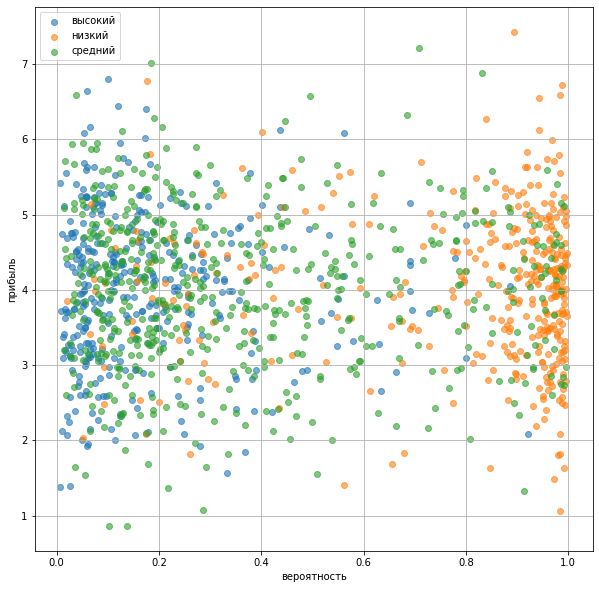

In [413]:
scatter_attr(dataset_market, 'страниц_за_визит_3_кат')

Покупатели с количеством просматриваемых страниц за визит менее шести, преимущественно локализованы в зоне высоких вероятностей.

### Предложения по сокращению снижения покупательской активности

Если отобрать покупателей, с количеством неоплаченых товаров в корзине свыше шести и которые разрешили сообщения от магазина, то получим сегмент покупателей с возможностью прямого влияния.

In [326]:
dataset_target = dataset_market[(dataset_market['разрешить_сообщать'] == 'да') &\
                                (dataset_market['неоплаченные_продукты_штук_квартал'] > 6)]
dataset_target.shape[0]

47

Всего 47 покупателей.

## Вывод

В ходе работы были достигнуты все ранее поставленные цели.

    - Были успешно загружены предоставленные данные. Подобраны корректные разделители значений признаков и дробной части вещественного числа.

    - В ходе предварительной обработки не было выявленно пропусков в данных. Устранены явные и неявные дубликаты в записях данных.

    - В рамках исследовательского анализа, выявлен и устранён аномальный выброс в значениях признака 'выручка'. Установленна ненормальность рапределения всех численных-непрерыных признаков, за исключением признака 'прибыль'. Построены графики распределений значений как категориальных, так и численных дискретных признаков.

    - Все предварительно обработанные данные были последовательно и корректно объеденены в один набор данных.
    
    - В результате проведения корреляционного анализа, выявлена умеренная мультиколлениарность между распределениями значений признаков 'выручка_предыдущий_месяц' и 'выручка_текущий_месяц'. Дополнительно для численных признаков, были расчитаны коэффициенты инфляции дисперсии (VIF). 

    - Была успешно построена и обучена конструкция конвейрного препроцессинга данных. Признаки были разделены на три вида по типу кодирования (ординального или one-hot) или масштабирования (мин/макс или нормализации).
    
    - Была успешно построена и обучена конструкция конвейрного случайного перебора четырёх линейных классификаторов с индивидуальными наборами гиперпараметров. Была произведена оценка качества классификации по двум метрикам (recall и roc_auc) и в итоге выбран лучший классификатор.
    
    - Была показана возможность ручного улучшения классификации и риски связанные с предложенным методом.
    
    - Был произведён анализ влияния значений признаков на классификацию объектов. Выявлены наиболее влиятельные на классификацию объектов признаки, как признаки наблюдения так и признаки прямого воздействия. Определены причинно-следственные связи между характеристиками изменений значений влияющих признаков и соответчтвующие им тенденций классификаций объектов. Построены соответсвующие графики.
    
    - С использованием обнаруженной информации и построенного классификатора, была проведена сегментация объектов по целой гамме признаков. Сегментация позволила выявить группы объектов с явной склонностью к снижению лояльности. Что, в свою очередь, позволило сформировать ряд предложений заказчику, о персонализации взаимодействий с объектами, такими как изменение состава категорий акционных товаров, снижение состава невыкупленных товаров в корзине и пр.